# Tests de TextTokenizarion puis d'Embedding

In [2]:
import time
import pathlib
import gzip

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import layers

try:
    from tensorflow.keras.layers import TextVectorization
except ImportError:
    from tensorflow.keras.layers.experimental.preprocessing import TextVectorization


from sklearn.model_selection import train_test_split

random_seed = 0
np.random.seed(random_seed)

# set random seed for keras reproductibility
try:
    keras.utils.set_random_seed(random_seed)
except Exception:
    tf.random.set_seed(random_seed)
    
    
import gc
gc.enable()

2022-08-04 23:17:33.271137: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


2022-08-04 23:17:35.816544: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-08-04 23:17:35.819166: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-08-04 23:17:35.859849: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-04 23:17:35.860610: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:1e.0 name: Tesla T4 computeCapability: 7.5
coreClock: 1.59GHz coreCount: 40 deviceMemorySize: 14.75GiB deviceMemoryBandwidth: 298.08GiB/s
2022-08-04 23:17:35.860671: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-08-04 23:17:35.862841: I tensorflow/stream_executor/platform/default/dso_loade

In [4]:
import FreeMobileSMS as sms

In [5]:
from classification_utils import fit_model, get_scores, init_scores

init_scores("data/scores_NN_SelectEmbeddingTESTS.csv")

In [6]:
data_work = pd.read_csv(
    pathlib.Path(pathlib.Path().absolute(), 'data', 'data_nlp_1563108.csv'), 
    usecols=['target', 'lemmas_not_filtered'],
    encoding='ISO-8859-1',
    #nrows=100000,
)
data_work.rename(columns={'lemmas_not_filtered':'text'}, inplace=True)
display(data_work.head(), data_work.shape)
data_work = data_work.groupby('target', group_keys=False).apply(lambda x: x.sample(50000, random_state=random_seed))
display(data_work.head(), data_work.shape)

,target,text
0,0,"$ url$ - awww , that be a bummer . you shoulda..."
1,0,be upset that he can not update his facebook b...
2,0,I dive many time for the ball . manage to save...
3,0,my whole body feel itchy and like its on fire
4,0,"no , it be not behave at all . I be mad . why ..."


(1452791, 2)

,target,text
469259,0,I do not have a background for my twitter stre...
152271,0,I do many thing but miss tweet
597612,0,most probably - eww all that pasty white skin ...
708306,0,"ohh , how bad I sleep"
59100,0,"hell yeah u be texte I I remember , I be at my..."


(100000, 2)

In [7]:
data_work.target.value_counts(dropna=False)

0    50000
1    50000
Name: target, dtype: int64

In [8]:
def architecture001(f_opti, f_loss, f_metrics, max_tokens=20000, hidden_dim=16):
        
    inputs = keras.Input(shape=(max_tokens,), dtype="int64")
    
    x = layers.Dense(hidden_dim, activation='relu')(inputs)
    x = layers.Dropout(0.5)(x)
    
    predictions = layers.Dense(1, activation='sigmoid', name='predictions')(x)
    
    model = keras.Model(inputs, predictions)
    model.compile(loss=f_loss, optimizer=f_opti, metrics=f_metrics)
    
    return model

In [9]:
def architecture002_oh(f_opti, f_loss, f_metrics, voc_size):
        
    inputs = keras.Input(shape=(None,), dtype="int64")
    
    x = tf.one_hot(inputs, depth=voc_size)
    x = layers.Bidirectional(layers.LSTM(32))(x) # 64
    x = layers.Dropout(0.5)(x)
    
    predictions = layers.Dense(1, activation='sigmoid', name='predictions')(x)
    
    model = keras.Model(inputs, predictions)
    model.compile(loss=f_loss, optimizer=f_opti, metrics=f_metrics)
    
    return model

In [10]:
def architecture002(f_opti, f_loss, f_metrics, embedding):
        
    inputs = keras.Input(shape=(None,), dtype="int64")
    
    x = embedding(inputs)
    x = layers.Bidirectional(layers.LSTM(32))(x) # 64
    x = layers.Dropout(0.5)(x)
    
    predictions = layers.Dense(1, activation='sigmoid', name='predictions')(x)
    
    model = keras.Model(inputs, predictions)
    model.compile(loss=f_loss, optimizer=f_opti, metrics=f_metrics)
    
    return model

In [11]:
def architecture003(f_opti, f_loss, f_metrics, embedding):
        
    inputs = keras.Input(shape=(None,), dtype="int64")
    
    x = embedding(inputs)
    x = layers.Bidirectional(layers.LSTM(64))(x)
    x = layers.Dense(24, activation='relu')(x)
    
    predictions = layers.Dense(1, activation='sigmoid', name='predictions')(x)
    
    model = keras.Model(inputs, predictions)
    model.compile(loss=f_loss, optimizer=f_opti, metrics=f_metrics)
    
    return model

In [12]:
from keras import layers
from keras.callbacks import EarlyStopping, ModelCheckpoint, Callback, ReduceLROnPlateau

def init_callbacks2(model_name):

    # Define savepoints
    filepath = pathlib.Path("models", f"{model_name}.keras")

    checkpoint = ModelCheckpoint(
        monitor="val_accuracy",
        mode="max",
        filepath=filepath,
        save_best_only=True,
        verbose=1,
    )

    # Define EarlyStopping conditions
    es = EarlyStopping(
        monitor='val_loss', # 'binary_accuracy'
        mode='min', # 'max'
        patience=5,
        min_delta=0.01, 
        restore_best_weights=True, 
        verbose=1,
    )
    
    return [checkpoint, es]

In [13]:
from gensim.models import KeyedVectors
import gensim.downloader as api

def load_gensim_embedding(embedding_name, binary=False):
    
    embedding_path = pathlib.Path(pathlib.Path().absolute(), 'data', 'embedding_models', f'{embedding_name}.gz')
    try:
        if embedding_path.is_file():
            print(f"Loading from {embedding_path}")
            embedding_model = KeyedVectors.load_word2vec_format(embedding_path, binary=binary)
        else:
            print("Loading from the Git repos with API")
            embedding_model = api.load(embedding_name)
            
        return embedding_model
    except Exception as e:
        print(f"The provided embedding model couldn't be loaded correctly: {e}")
        
def load_trained_glove(embedding_name):
    
    def parse_file(file):
        embeddings_index = {}
        for line in file:
            word, coefs = line.split(maxsplit=1)
            coefs = np.fromstring(coefs, "f", sep=" ")
            embeddings_index[word] = coefs
        return embeddings_index

    try:
        embedding_path = pathlib.Path(pathlib.Path().absolute(), 'data', 'embedding_models', f'{embedding_name}.gz')
        if embedding_path.is_file():
            print(f"Loading from gZip: {embedding_path}")
            with gzip.open(embedding_path, mode='rt') as f:
                return parse_file(f)
        
        embedding_path = pathlib.Path(pathlib.Path().absolute(), 'data', 'embedding_models', f'{embedding_name}.txt')
        if embedding_path.is_file():
            print(f"Loading from TXT: {embedding_path}")
            with open(embedding_path) as f:
                return parse_file(f)
        else:
            raise FileNotFoundError(f"No such model found (it must be {embedding_name}.txt or {embedding_name}.gz)")
            
    except Exception as e:
        print(f"The provided embedding model couldn't be loaded correctly: {e}")

In [14]:
def convert_embedding_matrix(vocabulary, embeddings_index, max_tokens, embedding_dim=100):
    
    hits = 0
    misses = 0
    misses_list = []
    
    word_index = dict(zip(vocabulary, range(len(vocabulary))))
    
    embedding_matrix = np.zeros((max_tokens, embedding_dim))
    
    for word, i in word_index.items():
        if i < max_tokens:
            try:
                embedding_vector = embeddings_index.get_vector(word)
            except AttributeError:
                embedding_vector = embeddings_index.get(word)
            except KeyError:
                embedding_vector = None
        if embedding_vector is not None:
            hits += 1
            embedding_matrix[i] = embedding_vector
        else:
            misses += 1
            misses_list.append(word)
            
    print(f"Converted {hits} words, and couldn't find {misses} words")
    print(f"Missing words: {misses_list}")
            
    return embedding_matrix

In [15]:
batch_size=1024

### Divisons le jeu de données en `Train` et `Test` sets

In [16]:
X_train, X_test, y_train, y_test = train_test_split(data_work['text'], data_work['target'], test_size=0.2, random_state=random_seed, stratify=data_work['target'])

In [17]:
sms.send("Starting Bag of words models", stop=False)

## Bags of words / Bag of N-gram models

### Test A0 - NN | Ngram=2 | int

#### Standardize & Tokenize

In [19]:
text_vectorization0 = TextVectorization(
    output_mode='int', # int, multi_hot, count, tf_idf
    max_tokens=20000,
    ngrams=2,
    output_sequence_length=79 # search the max size by default
)

In [20]:
text_vectorization0.adapt(list(data_work.text), True)

In [21]:
print(text_vectorization0.get_vocabulary()[:20], "...")

['', '[UNK]', 'i', 'be', 'to', 'the', 'a', 'not', 'my', 'and', 'it', 'you', 'have', 'do', 'for', 'in', 'i be', 'go', 'of', 'that'] ...


#### Prepare dataset

In [22]:
X_train_ready = text_vectorization0(X_train)
X_test_ready = text_vectorization0(X_test)

In [23]:
X_train[:2]

164240          sit in bed where I will be for the weekend .
1084963    home sweet home , back from a great saturday a...
Name: text, dtype: object

In [24]:
X_train_ready[:2]

<tf.Tensor: shape=(2, 79), dtype=int64, numpy=
array([[  379,    15,   167,   276,     2,    31,     3,    14,     5,
          185,  1412,   850,     1,  1825,    98,   168,  1549,   110,
          979,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0],
       [   91,   518,    91,    64,    65,     6,   111,   613,     9,
          434,    26,     1,     1, 15935, 14474,     1,   701,  1294,
          312,     1, 13644, 16284,     1,     1,     1,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0, 

#### Train model

In [25]:
model = architecture001("adam", "binary_crossentropy", ['accuracy'], X_train_ready[:0].shape[1])

In [26]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 79)]              0         
_________________________________________________________________
dense (Dense)                (None, 16)                1280      
_________________________________________________________________
dropout (Dropout)            (None, 16)                0         
_________________________________________________________________
predictions (Dense)          (None, 1)                 17        
Total params: 1,297
Trainable params: 1,297
Non-trainable params: 0
_________________________________________________________________


In [27]:
t0 = time.perf_counter()
history = model.fit(
        x=X_train_ready, y=y_train, 
        validation_data=(X_test_ready, y_test), 
        epochs=50, 
        batch_size=batch_size, 
        callbacks=init_callbacks2(f"MINI_TESTS_A00"),
        verbose=1,
)
train_time = time.perf_counter() - t0

Epoch 1/50


2022-08-04 23:17:58.709578: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-08-04 23:17:58.728701: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2499995000 Hz


 1/79 [..............................] - ETA: 40s - loss: 1768.3793 - accuracy: 0.4922

2022-08-04 23:17:59.073832: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10


79/79 [==============================] - 1s 8ms/step - loss: 1202.4928 - accuracy: 0.4996 - val_loss: 309.5540 - val_accuracy: 0.4931

Epoch 00001: val_accuracy improved from -inf to 0.49315, saving model to models/MINI_TESTS_A00.keras
Epoch 2/50
79/79 [==============================] - 0s 2ms/step - loss: 382.3845 - accuracy: 0.5027 - val_loss: 111.6692 - val_accuracy: 0.4967

Epoch 00002: val_accuracy improved from 0.49315 to 0.49675, saving model to models/MINI_TESTS_A00.keras
Epoch 3/50
79/79 [==============================] - 0s 3ms/step - loss: 113.6705 - accuracy: 0.5017 - val_loss: 37.3080 - val_accuracy: 0.5026

Epoch 00003: val_accuracy improved from 0.49675 to 0.50255, saving model to models/MINI_TESTS_A00.keras
Epoch 4/50
79/79 [==============================] - 0s 3ms/step - loss: 34.4306 - accuracy: 0.5052 - val_loss: 14.1736 - val_accuracy: 0.5023

Epoch 00004: val_accuracy did not improve from 0.50255
Epoch 5/50
79/79 [==============================] - 0s 2ms/step - los

In [28]:
model = keras.models.load_model("models/MINI_TESTS_A00.keras")

In [29]:
model.evaluate(X_test_ready, y_test)

625/625 [==============================] - 1s 906us/step - loss: 0.7583 - accuracy: 0.5131


[0.7582582235336304, 0.5131499767303467]

In [30]:
raw_txt = tf.convert_to_tensor(["I hate it", "I love it"])
raw_txt = text_vectorization0(raw_txt)
model.predict(raw_txt)

array([[0.5123604],
       [0.5043814]], dtype=float32)

In [31]:
t0 = time.perf_counter()
raw_txt = tf.convert_to_tensor(X_test)
raw_txt = text_vectorization0(raw_txt)
y_preds_proba = model.predict(raw_txt)
y_preds = np.where(y_preds_proba > 0.5, 1,0)
inf_time = time.perf_counter() - t0

----------------------------------------------------------------------------------------------------
          These information are based on the best estimator of the above cross-validation           
----------------------------------------------------------------------------------------------------

--- Test A00 ---------------------------------------------------------------------------------------

             ROC_AUC : 0.5100
                  F1 : 0.3390
            ACCURACY : 0.5131
           PRECISION : 0.5278
              RECALL : 0.2497
   AVERAGE_PRECISION : 0.5059

       TRAINING-TIME : 7.6795
      INFERENCE-TIME : 0.6094

--- Classification Report -------------------------------------------------------------------------- 

                 precision    recall  f1-score   support

Prediction = 0       0.51      0.78      0.61     10000
Prediction = 1       0.53      0.25      0.34     10000

      accuracy                           0.51     20000
     macro avg       0

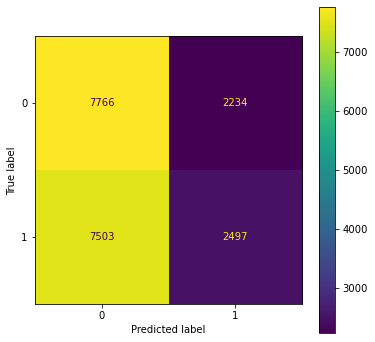

--- ROC AUC ---------------------------------------------------------------------------------------- 



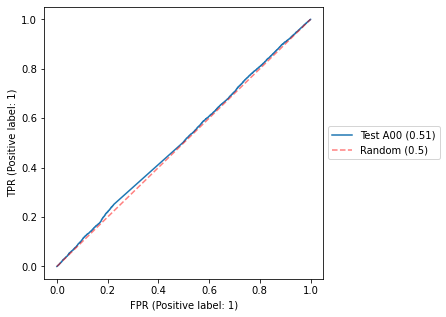

--- PRECISION RECALL AUC --------------------------------------------------------------------------- 



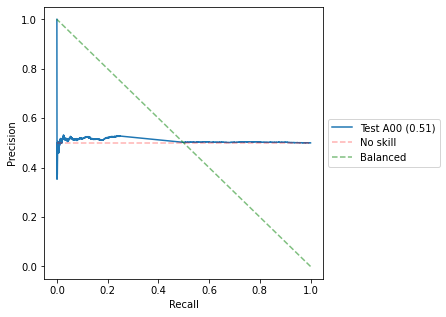

In [32]:
model_name = "Test A00"
get_scores(model_name, y_pred=y_preds, y_pred_proba=y_preds_proba, register=True, X_ref=X_test_ready, y_ref=y_test, training_time=train_time, inference_time=inf_time)

In [33]:
del text_vectorization0

#### Compare

In [34]:
from classification_utils import scores_df
scores_df

,Method,threshold,params,ROC AUC,PR AUC,F1 score,Accuracy,Precision,Recall,TP,TN,FP,FN,Training time,Inference time
0,Test A00,None,None,0.510002,0.505938,0.339013,0.51315,0.527795,0.2497,2497,7766,2234,7503,7.679453,0.609395


In [35]:
sms.send("TestA00 Done", stop=False)

### Test A1 - NN | Ngram=1 | multi_hot

#### Standardize & Tokenize

### Test A2 - NN | Ngram=2 | multi_hot

#### Standardize & Tokenize

### Test A3 - NN | Ngram=2 | count

#### Standardize & Tokenize

In [36]:
text_vectorization3 = TextVectorization(
    output_mode='count', # int, multi_hot, count, tf_idf
    max_tokens=20000,
    ngrams=2,
    # output_sequence_length=60 # search the max size by default
)

In [37]:
text_vectorization3.adapt(list(data_work.text), True)

In [38]:
print(text_vectorization3.get_vocabulary()[:20], "...")

['[UNK]', 'i', 'be', 'to', 'the', 'a', 'not', 'my', 'and', 'it', 'you', 'have', 'do', 'for', 'in', 'i be', 'go', 'of', 'that', 'get'] ...


#### Prepare dataset

In [39]:
X_train_ready = text_vectorization3(X_train)
X_test_ready = text_vectorization3(X_test)

2022-08-04 23:18:12.737671: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 6400000000 exceeds 10% of free system memory.
2022-08-04 23:18:14.344867: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1600000000 exceeds 10% of free system memory.


In [40]:
X_train[:2]

164240          sit in bed where I will be for the weekend .
1084963    home sweet home , back from a great saturday a...
Name: text, dtype: object

In [41]:
X_train_ready[:2]

<tf.Tensor: shape=(2, 20000), dtype=float32, numpy=
array([[1., 1., 1., ..., 0., 0., 0.],
       [7., 0., 0., ..., 0., 0., 0.]], dtype=float32)>

#### Train model

In [42]:
model = architecture001("adam", "binary_crossentropy", ['accuracy'], X_train_ready[:0].shape[1])

In [43]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 20000)]           0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                320016    
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
predictions (Dense)          (None, 1)                 17        
Total params: 320,033
Trainable params: 320,033
Non-trainable params: 0
_________________________________________________________________


In [44]:
t0 = time.perf_counter()
history = model.fit(
        x=X_train_ready, y=y_train, 
        validation_data=(X_test_ready, y_test), 
        epochs=50, 
        batch_size=batch_size, 
        callbacks=init_callbacks2(f"MINI_TESTS_A03"),
        verbose=1,
)
train_time = time.perf_counter() - t0

Epoch 1/50
79/79 [==============================] - 4s 47ms/step - loss: 0.6510 - accuracy: 0.6387 - val_loss: 0.5344 - val_accuracy: 0.7764

Epoch 00001: val_accuracy improved from -inf to 0.77635, saving model to models/MINI_TESTS_A03.keras
Epoch 2/50
79/79 [==============================] - 4s 45ms/step - loss: 0.5208 - accuracy: 0.7772 - val_loss: 0.4858 - val_accuracy: 0.7917

Epoch 00002: val_accuracy improved from 0.77635 to 0.79170, saving model to models/MINI_TESTS_A03.keras
Epoch 3/50
79/79 [==============================] - 4s 45ms/step - loss: 0.4668 - accuracy: 0.8030 - val_loss: 0.4656 - val_accuracy: 0.7975

Epoch 00003: val_accuracy improved from 0.79170 to 0.79745, saving model to models/MINI_TESTS_A03.keras
Epoch 4/50
79/79 [==============================] - 4s 45ms/step - loss: 0.4332 - accuracy: 0.8219 - val_loss: 0.4560 - val_accuracy: 0.7963

Epoch 00004: val_accuracy did not improve from 0.79745
Epoch 5/50
79/79 [==============================] - 4s 45ms/step - l

#### Evaluate

In [45]:
model = keras.models.load_model("models/MINI_TESTS_A03.keras")

In [46]:
model.evaluate(X_test_ready, y_test)

625/625 [==============================] - 1s 2ms/step - loss: 0.4656 - accuracy: 0.7975


[0.4655972123146057, 0.7974500060081482]

In [47]:
raw_txt = tf.convert_to_tensor(["I hate it", "I love it"])
raw_txt = text_vectorization3(raw_txt)
model.predict(raw_txt)

array([[0.17941916],
       [0.860192  ]], dtype=float32)

In [48]:
t0 = time.perf_counter()
raw_txt = tf.convert_to_tensor(X_test)
raw_txt = text_vectorization3(raw_txt)
y_preds_proba = model.predict(raw_txt)
y_preds = np.where(y_preds_proba > 0.5, 1,0)
inf_time = time.perf_counter() - t0

2022-08-04 23:18:53.870271: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1600000000 exceeds 10% of free system memory.


----------------------------------------------------------------------------------------------------
          These information are based on the best estimator of the above cross-validation           
----------------------------------------------------------------------------------------------------

--- Test A03 ---------------------------------------------------------------------------------------

             ROC_AUC : 0.8666
                  F1 : 0.7931
            ACCURACY : 0.7974
           PRECISION : 0.8104
              RECALL : 0.7766
   AVERAGE_PRECISION : 0.8664

       TRAINING-TIME : 36.2416
      INFERENCE-TIME : 1.5812

--- Classification Report -------------------------------------------------------------------------- 

                 precision    recall  f1-score   support

Prediction = 0       0.79      0.82      0.80     10000
Prediction = 1       0.81      0.78      0.79     10000

      accuracy                           0.80     20000
     macro avg       

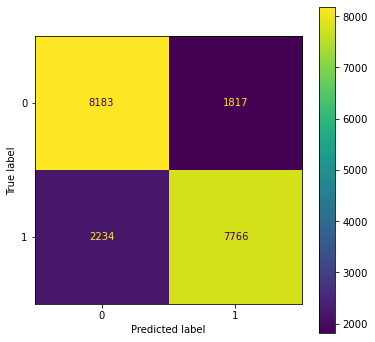

--- ROC AUC ---------------------------------------------------------------------------------------- 



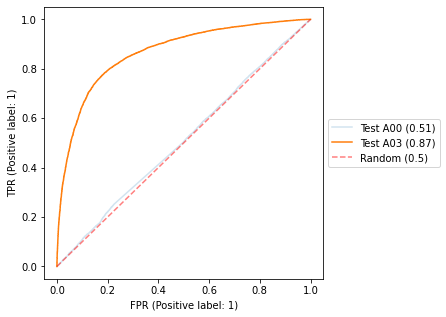

--- PRECISION RECALL AUC --------------------------------------------------------------------------- 



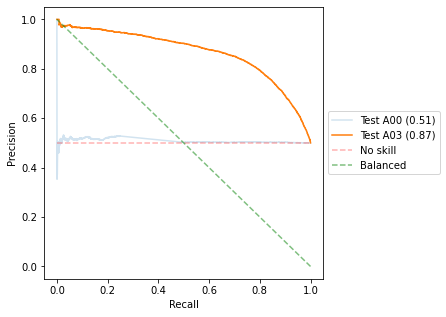

In [49]:
model_name = "Test A03"
get_scores(model_name, y_pred=y_preds, y_pred_proba=y_preds_proba, register=True, X_ref=X_test_ready, y_ref=y_test, training_time=train_time, inference_time=inf_time)

In [50]:
del text_vectorization3

#### Compare

In [51]:
from classification_utils import scores_df
scores_df

,Method,threshold,params,ROC AUC,PR AUC,F1 score,Accuracy,Precision,Recall,TP,TN,FP,FN,Training time,Inference time
0,Test A00,None,None,0.510002,0.505938,0.339013,0.51315,0.527795,0.2497,2497,7766,2234,7503,7.679453,0.609395
1,Test A03,None,None,0.866633,0.866372,0.793137,0.79745,0.810393,0.7766,7766,8183,1817,2234,36.241583,1.581173


In [52]:
sms.send("TestA03 Done", stop=False)

### Test A4 - NN | Ngram=2 | tf-idf

#### Standardize & Tokenize

In [53]:
text_vectorization4 = TextVectorization(
    output_mode='tf_idf', # int, multi_hot, count, tf_idf
    max_tokens=20000,
    ngrams=2,
    # output_sequence_length=60 # search the max size by default
)

ValueError: TextVectorization's output_mode arg received an invalid value tf_idf. Allowed values are `None`, or one of the following values: ('int', 'count', 'binary', 'tf-idf').

In [ ]:
text_vectorization4.adapt(data_work.text)

In [ ]:
print(text_vectorization4.get_vocabulary()[:20], "...")

#### Prepare dataset

In [ ]:
X_train_ready = text_vectorization4(X_train)
X_test_ready = text_vectorization4(X_test)

In [ ]:
X_train[:2]

In [ ]:
X_train_ready[:2]

#### Train model

In [ ]:
model = architecture001("adam", "binary_crossentropy", ['accuracy'], X_train_ready[:0].shape[1])

In [ ]:
model.summary()

In [ ]:
t0 = time.perf_counter()
history = model.fit(
        x=X_train_ready, y=y_train, 
        validation_data=(X_test_ready, y_test), 
        epochs=50, 
        batch_size=batch_size, 
        callbacks=init_callbacks2(f"MINI_TESTS_A04"),
        verbose=1,
)
train_time = time.perf_counter() - t0

#### Evaluate

In [ ]:
model = keras.models.load_model("models/MINI_TESTS_A04.keras")

In [ ]:
model.evaluate(X_test_ready, y_test)

In [ ]:
raw_txt = tf.convert_to_tensor(["I hate it", "I love it"])
raw_txt = text_vectorization4(raw_txt)
model.predict(raw_txt)

In [ ]:
t0 = time.perf_counter()
raw_txt = tf.convert_to_tensor(X_test)
raw_txt = text_vectorization4(raw_txt)
y_preds_proba = model.predict(raw_txt)
y_preds = np.where(y_preds_proba > 0.5, 1,0)
inf_time = time.perf_counter() - t0

In [ ]:
model_name = "Test A04"
get_scores(model_name, y_pred=y_preds, y_pred_proba=y_preds_proba, register=True, X_ref=X_test_ready, y_ref=y_test, training_time=train_time, inference_time=inf_time)

#### Compare

In [ ]:
from classification_utils import scores_df
scores_df

In [ ]:
sms.send("TestA04 Done", stop=False)

## Sequential models

### Test B0 - RNN | Ngram=2 | int | One-hot Embedding

#### Standardize & Tokenize

### Test B1 - RNN | Ngram=2 | int | Keras Embedding

#### Standardize & Tokenize

In [60]:
max_length = 60
max_tokens=20000

text_vectorizationB1 = TextVectorization(
    output_mode='int', # int, multi_hot, count, tf_idf
    max_tokens=max_tokens,
    ngrams=2,
    output_sequence_length=max_length # search the max size by default
)

In [61]:
text_vectorizationB1.adapt(list(data_work.text),True)

In [62]:
print(text_vectorizationB1.get_vocabulary()[:20], "...")

['', '[UNK]', 'i', 'be', 'to', 'the', 'a', 'not', 'my', 'and', 'it', 'you', 'have', 'do', 'for', 'in', 'i be', 'go', 'of', 'that'] ...


#### Prepare dataset

In [63]:
X_train_ready = text_vectorizationB1(X_train)
X_test_ready = text_vectorizationB1(X_test)

In [64]:
X_train[:2]

164240          sit in bed where I will be for the weekend .
1084963    home sweet home , back from a great saturday a...
Name: text, dtype: object

In [65]:
X_train_ready[:2]

<tf.Tensor: shape=(2, 60), dtype=int64, numpy=
array([[  379,    15,   167,   276,     2,    31,     3,    14,     5,
          185,  1412,   850,     1,  1825,    98,   168,  1549,   110,
          979,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0],
       [   91,   518,    91,    64,    65,     6,   111,   613,     9,
          434,    26,     1,     1, 15935, 14474,     1,   701,  1294,
          312,     1, 13644, 16284,     1,     1,     1,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0]]

#### Train model

In [66]:
# Embedding simple
embedding_layer = layers.Embedding(
    input_dim=max_tokens,
    output_dim=128, 
    input_length=X_train_ready.shape[1],
    # mask_zero=True,
    # trainable=True, # <== default is True
)

In [67]:
model = architecture002("adam", "binary_crossentropy", ['accuracy'], embedding_layer)

In [68]:
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, None)]            0         
_________________________________________________________________
embedding (Embedding)        (None, None, 128)         2560000   
_________________________________________________________________
bidirectional (Bidirectional (None, 64)                41216     
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
predictions (Dense)          (None, 1)                 65        
Total params: 2,601,281
Trainable params: 2,601,281
Non-trainable params: 0
_________________________________________________________________


In [69]:
t0 = time.perf_counter()
history = model.fit(
        x=X_train_ready, y=y_train, 
        validation_data=(X_test_ready, y_test), 
        epochs=50, 
        batch_size=batch_size, 
        callbacks=init_callbacks2(f"MINI_TESTS_B01"),
        verbose=1,
)
train_time = time.perf_counter() - t0

Epoch 1/50


2022-08-04 23:19:52.595172: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7


79/79 [==============================] - 7s 52ms/step - loss: 0.6510 - accuracy: 0.6111 - val_loss: 0.4787 - val_accuracy: 0.7794

Epoch 00001: val_accuracy improved from -inf to 0.77945, saving model to models/MINI_TESTS_B01.keras
Epoch 2/50
79/79 [==============================] - 4s 46ms/step - loss: 0.4408 - accuracy: 0.8129 - val_loss: 0.4556 - val_accuracy: 0.7941

Epoch 00002: val_accuracy improved from 0.77945 to 0.79415, saving model to models/MINI_TESTS_B01.keras
Epoch 3/50
79/79 [==============================] - 4s 46ms/step - loss: 0.3736 - accuracy: 0.8504 - val_loss: 0.4589 - val_accuracy: 0.7903

Epoch 00003: val_accuracy did not improve from 0.79415
Epoch 4/50
79/79 [==============================] - 4s 45ms/step - loss: 0.3358 - accuracy: 0.8692 - val_loss: 0.4788 - val_accuracy: 0.7861

Epoch 00004: val_accuracy did not improve from 0.79415
Epoch 5/50
79/79 [==============================] - 4s 46ms/step - loss: 0.2999 - accuracy: 0.8837 - val_loss: 0.5267 - val_accu

#### Evaluate

In [70]:
model = keras.models.load_model("models/MINI_TESTS_B01.keras")

In [71]:
model.evaluate(X_test_ready, y_test)

625/625 [==============================] - 2s 3ms/step - loss: 0.4556 - accuracy: 0.7941


[0.4556029736995697, 0.7941499948501587]

In [72]:
raw_txt = tf.convert_to_tensor(["I hate it", "I love it"])
raw_txt = text_vectorizationB1(raw_txt)
model.predict(raw_txt)

array([[0.11942051],
       [0.9048571 ]], dtype=float32)

In [73]:
t0 = time.perf_counter()
raw_txt = tf.convert_to_tensor(X_test)
raw_txt = text_vectorizationB1(raw_txt)
y_preds_proba = model.predict(raw_txt)
y_preds = np.where(y_preds_proba > 0.5, 1,0)
inf_time = time.perf_counter() - t0

----------------------------------------------------------------------------------------------------
          These information are based on the best estimator of the above cross-validation           
----------------------------------------------------------------------------------------------------

--- Test B01 ---------------------------------------------------------------------------------------

             ROC_AUC : 0.8683
                  F1 : 0.7908
            ACCURACY : 0.7942
           PRECISION : 0.8038
              RECALL : 0.7782
   AVERAGE_PRECISION : 0.8670

       TRAINING-TIME : 29.1953
      INFERENCE-TIME : 2.6492

--- Classification Report -------------------------------------------------------------------------- 

                 precision    recall  f1-score   support

Prediction = 0       0.79      0.81      0.80     10000
Prediction = 1       0.80      0.78      0.79     10000

      accuracy                           0.79     20000
     macro avg       

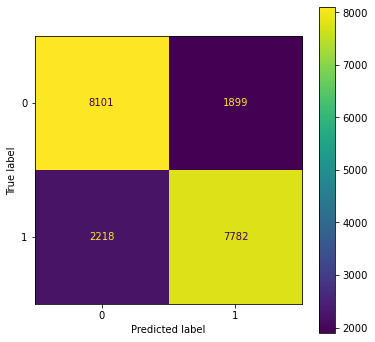

--- ROC AUC ---------------------------------------------------------------------------------------- 



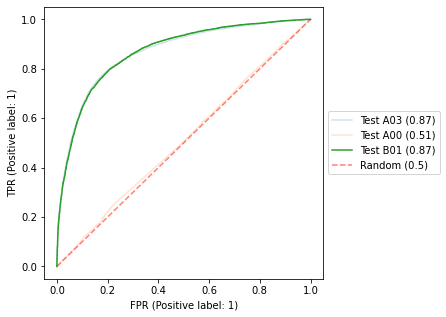

--- PRECISION RECALL AUC --------------------------------------------------------------------------- 



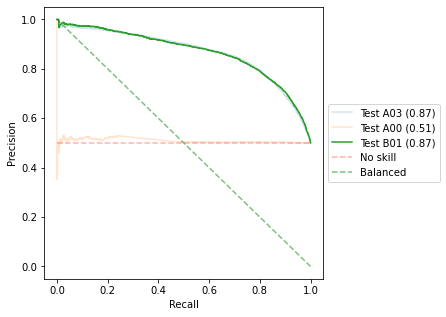

In [74]:
model_name = "Test B01"
get_scores(model_name, y_pred=y_preds, y_pred_proba=y_preds_proba, register=True, X_ref=X_test_ready, y_ref=y_test, training_time=train_time, inference_time=inf_time)

#### Compare

In [75]:
from classification_utils import scores_df
scores_df

,Method,threshold,params,ROC AUC,PR AUC,F1 score,Accuracy,Precision,Recall,TP,TN,FP,FN,Training time,Inference time
0,Test A00,None,None,0.510002,0.505938,0.339013,0.51315,0.527795,0.2497,2497,7766,2234,7503,7.679453,0.609395
1,Test A03,None,None,0.866633,0.866372,0.793137,0.79745,0.810393,0.7766,7766,8183,1817,2234,36.241583,1.581173
2,Test B01,None,None,0.868323,0.866994,0.790813,0.79415,0.803843,0.7782,7782,8101,1899,2218,29.195286,2.649221


In [76]:
sms.send("TestB01 Done", stop=False)

### Test B2 - RNN | Ngram=2 | int | Keras Embedding + MASK

#### Standardize & Tokenize

In [77]:
max_length = 60
max_tokens=20000

text_vectorizationB2 = TextVectorization(
    output_mode='int', # int, multi_hot, count, tf_idf
    max_tokens=max_tokens,
    ngrams=2,
    output_sequence_length=max_length # search the max size by default
)

In [79]:
text_vectorizationB2.adapt(list(data_work.text),True)

In [80]:
print(text_vectorizationB2.get_vocabulary()[:20], "...")

['', '[UNK]', 'i', 'be', 'to', 'the', 'a', 'not', 'my', 'and', 'it', 'you', 'have', 'do', 'for', 'in', 'i be', 'go', 'of', 'that'] ...


#### Prepare dataset

In [81]:
X_train_ready = text_vectorizationB2(X_train)
X_test_ready = text_vectorizationB2(X_test)

In [82]:
X_train[:2]

164240          sit in bed where I will be for the weekend .
1084963    home sweet home , back from a great saturday a...
Name: text, dtype: object

In [83]:
X_train_ready[:2]

<tf.Tensor: shape=(2, 60), dtype=int64, numpy=
array([[  379,    15,   167,   276,     2,    31,     3,    14,     5,
          185,  1412,   850,     1,  1825,    98,   168,  1549,   110,
          979,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0],
       [   91,   518,    91,    64,    65,     6,   111,   613,     9,
          434,    26,     1,     1, 15935, 14474,     1,   701,  1294,
          312,     1, 13644, 16284,     1,     1,     1,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0]]

#### Train model

In [84]:
# Embedding avec masque
embedding_layer = layers.Embedding(
    input_dim=max_tokens,
    output_dim=128, 
    input_length=X_train_ready.shape[1],
    mask_zero=True,
    # trainable=True, # <== default is True
)

In [85]:
model = architecture002("adam", "binary_crossentropy", ['accuracy'], embedding_layer)

In [86]:
model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, None)]            0         
_________________________________________________________________
embedding_1 (Embedding)      (None, None, 128)         2560000   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64)                41216     
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
_________________________________________________________________
predictions (Dense)          (None, 1)                 65        
Total params: 2,601,281
Trainable params: 2,601,281
Non-trainable params: 0
_________________________________________________________________


In [87]:
t0 = time.perf_counter()
history = model.fit(
        x=X_train_ready, y=y_train, 
        validation_data=(X_test_ready, y_test), 
        epochs=50, 
        batch_size=batch_size, 
        callbacks=init_callbacks2(f"MINI_TESTS_B02"),
        verbose=1,
)
train_time = time.perf_counter() - t0

Epoch 1/50
79/79 [==============================] - 14s 110ms/step - loss: 0.6370 - accuracy: 0.6377 - val_loss: 0.4578 - val_accuracy: 0.7882

Epoch 00001: val_accuracy improved from -inf to 0.78820, saving model to models/MINI_TESTS_B02.keras
Epoch 2/50
79/79 [==============================] - 7s 88ms/step - loss: 0.4087 - accuracy: 0.8235 - val_loss: 0.4495 - val_accuracy: 0.7943

Epoch 00002: val_accuracy improved from 0.78820 to 0.79430, saving model to models/MINI_TESTS_B02.keras
Epoch 3/50
79/79 [==============================] - 7s 88ms/step - loss: 0.3517 - accuracy: 0.8547 - val_loss: 0.4605 - val_accuracy: 0.7886

Epoch 00003: val_accuracy did not improve from 0.79430
Epoch 4/50
79/79 [==============================] - 7s 88ms/step - loss: 0.3197 - accuracy: 0.8716 - val_loss: 0.4782 - val_accuracy: 0.7819

Epoch 00004: val_accuracy did not improve from 0.79430
Epoch 5/50
79/79 [==============================] - 7s 88ms/step - loss: 0.2884 - accuracy: 0.8850 - val_loss: 0.53

#### Evaluate

In [88]:
model = keras.models.load_model("models/MINI_TESTS_B02.keras")

In [89]:
model.evaluate(X_test_ready, y_test)

625/625 [==============================] - 4s 4ms/step - loss: 0.4495 - accuracy: 0.7943


[0.44945064187049866, 0.7943000197410583]

In [90]:
raw_txt = tf.convert_to_tensor(["I hate it", "I love it"])
raw_txt = text_vectorizationB2(raw_txt)
model.predict(raw_txt)

array([[0.05429555],
       [0.944416  ]], dtype=float32)

In [91]:
t0 = time.perf_counter()
raw_txt = tf.convert_to_tensor(X_test)
raw_txt = text_vectorizationB2(raw_txt)
y_preds_proba = model.predict(raw_txt)
y_preds = np.where(y_preds_proba > 0.5, 1,0)
inf_time = time.perf_counter() - t0

----------------------------------------------------------------------------------------------------
          These information are based on the best estimator of the above cross-validation           
----------------------------------------------------------------------------------------------------

--- Test B02 ---------------------------------------------------------------------------------------

             ROC_AUC : 0.8725
                  F1 : 0.7938
            ACCURACY : 0.7943
           PRECISION : 0.7958
              RECALL : 0.7917
   AVERAGE_PRECISION : 0.8739

       TRAINING-TIME : 49.2249
      INFERENCE-TIME : 3.6537

--- Classification Report -------------------------------------------------------------------------- 

                 precision    recall  f1-score   support

Prediction = 0       0.79      0.80      0.79     10000
Prediction = 1       0.80      0.79      0.79     10000

      accuracy                           0.79     20000
     macro avg       

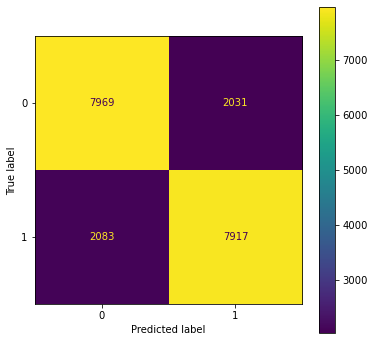

--- ROC AUC ---------------------------------------------------------------------------------------- 



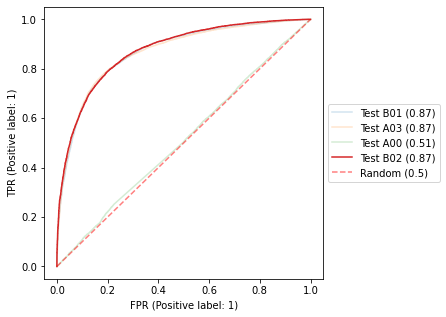

--- PRECISION RECALL AUC --------------------------------------------------------------------------- 



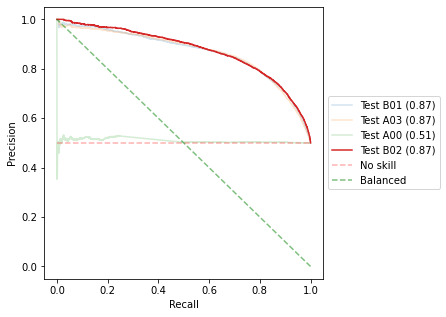

In [92]:
model_name = "Test B02"
get_scores(model_name, y_pred=y_preds, y_pred_proba=y_preds_proba, register=True, X_ref=X_test_ready, y_ref=y_test, training_time=train_time, inference_time=inf_time)

#### Compare

In [93]:
from classification_utils import scores_df
scores_df

,Method,threshold,params,ROC AUC,PR AUC,F1 score,Accuracy,Precision,Recall,TP,TN,FP,FN,Training time,Inference time
0,Test A00,None,None,0.510002,0.505938,0.339013,0.51315,0.527795,0.2497,2497,7766,2234,7503,7.679453,0.609395
1,Test A03,None,None,0.866633,0.866372,0.793137,0.79745,0.810393,0.7766,7766,8183,1817,2234,36.241583,1.581173
2,Test B01,None,None,0.868323,0.866994,0.790813,0.79415,0.803843,0.7782,7782,8101,1899,2218,29.195286,2.649221
3,Test B02,None,None,0.872496,0.873931,0.793764,0.79430,0.795838,0.7917,7917,7969,2031,2083,49.224950,3.653748


In [94]:
sms.send("TestB02 Done", stop=False)

### Test B3 - RNN | Ngram=2 | int | Glove 100d Embedding + MASK + NOT Trainable

#### Standardize & Tokenize

In [95]:
max_length = 60
max_tokens = 20000

text_vectorizationB3 = TextVectorization(
    output_mode='int', # int, multi_hot, count, tf_idf
    max_tokens=max_tokens,
    ngrams=2,
    output_sequence_length=max_length # search the max size by default
)

In [97]:
text_vectorizationB3.adapt(list(data_work.text),True)

In [98]:
print(text_vectorizationB3.get_vocabulary()[:20], "...")

['', '[UNK]', 'i', 'be', 'to', 'the', 'a', 'not', 'my', 'and', 'it', 'you', 'have', 'do', 'for', 'in', 'i be', 'go', 'of', 'that'] ...


#### Prepare dataset

In [99]:
X_train_ready = text_vectorizationB3(X_train)
X_test_ready = text_vectorizationB3(X_test)

In [100]:
X_train[:2]

164240          sit in bed where I will be for the weekend .
1084963    home sweet home , back from a great saturday a...
Name: text, dtype: object

In [101]:
X_train_ready[:2]

<tf.Tensor: shape=(2, 60), dtype=int64, numpy=
array([[  379,    15,   167,   276,     2,    31,     3,    14,     5,
          185,  1412,   850,     1,  1825,    98,   168,  1549,   110,
          979,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0],
       [   91,   518,    91,    64,    65,     6,   111,   613,     9,
          434,    26,     1,     1, 15935, 14474,     1,   701,  1294,
          312,     1, 13644, 16284,     1,     1,     1,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0]]

#### Embedding

In [102]:
embeddings_index = load_trained_glove("glove.6B.100d")

Loading from gZip: /home/jovyan/workspace/OC_AI_07/data/embedding_models/glove.6B.100d.gz


In [103]:
embedding_dim = 100
vocabulary = text_vectorizationB3.get_vocabulary()
embedding_matrix = convert_embedding_matrix(vocabulary, embeddings_index, max_tokens, embedding_dim)
embedding_matrix

Converted 5466 words, and couldn't find 14534 words
Missing words: ['', '[UNK]', 'i be', 'do not', 'it be', 'go to', 'can not', 'i have', 'i do', 'have a', 'be not', 'i m', 'be a', 'in the', 'i can', 'and i', 'i will', 'have to', 'be go', 'you be', 'to be', 'but i', 'for the', 'want to', 'that be', 'to go', 'on the', 'be so', 'i think', 'i love', 'to the', 'be the', 'to get', 'of the', 'i ve', 'i miss', 'i want', 'i know', 'will be', 'i just', 'i get', 'at the', 'get to', 'to do', 'on my', 'be in', 'for a', 'to see', 'wish i', 'need to', 'i need', 'so i', 'i feel', 'think i', 'get a', 'in a', 'to work', 'there be', 'a good', 'try to', 'now i', 'be on', 'will not', 'i wish', 'i would', 'not wait', 'i hate', 'i could', 'that i', 'have not', 'back to', 'he be', 'in my', 'i hope', 'for i', 'with my', 'of my', 'make i', 'not have', 'when i', 'not get', 'wake up', 'thank you', 'last night', 'so much', 'not be', 'they be', 'thank for', 'we be', 'you have', 'with the', 'right now', 'be you', '

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.046539  ,  0.61966002,  0.56647003, ..., -0.37616   ,
        -0.032502  ,  0.80620003],
       ...,
       [ 0.92246997,  0.5758    ,  0.18692   , ..., -0.10989   ,
        -0.15109999, -0.86754   ],
       [ 0.02524   ,  0.40887001,  1.00450003, ..., -0.11632   ,
        -0.51730001, -0.086215  ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [104]:
# Embedding avec masque
embedding_layer = layers.Embedding(
    input_dim=max_tokens,
    output_dim=embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    # input_length=max_length,
    mask_zero=True,
    trainable=False, # <== default is True
)

#### Train model

In [105]:
model = architecture002("adam", "binary_crossentropy", ['accuracy'], embedding_layer)

In [106]:
model.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, None)]            0         
_________________________________________________________________
embedding_2 (Embedding)      (None, None, 100)         2000000   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 64)                34048     
_________________________________________________________________
dropout_4 (Dropout)          (None, 64)                0         
_________________________________________________________________
predictions (Dense)          (None, 1)                 65        
Total params: 2,034,113
Trainable params: 34,113
Non-trainable params: 2,000,000
_________________________________________________________________


In [107]:
t0 = time.perf_counter()
history = model.fit(
        x=X_train_ready, y=y_train, 
        validation_data=(X_test_ready, y_test), 
        epochs=50, 
        batch_size=batch_size, 
        callbacks=init_callbacks2(f"MINI_TESTS_B03"),
        verbose=1,
)
train_time = time.perf_counter() - t0

Epoch 1/50
79/79 [==============================] - 11s 72ms/step - loss: 0.6676 - accuracy: 0.5772 - val_loss: 0.5667 - val_accuracy: 0.7071

Epoch 00001: val_accuracy improved from -inf to 0.70715, saving model to models/MINI_TESTS_B03.keras
Epoch 2/50
79/79 [==============================] - 4s 51ms/step - loss: 0.5592 - accuracy: 0.7138 - val_loss: 0.5375 - val_accuracy: 0.7287

Epoch 00002: val_accuracy improved from 0.70715 to 0.72870, saving model to models/MINI_TESTS_B03.keras
Epoch 3/50
79/79 [==============================] - 4s 51ms/step - loss: 0.5379 - accuracy: 0.7279 - val_loss: 0.5232 - val_accuracy: 0.7391

Epoch 00003: val_accuracy improved from 0.72870 to 0.73915, saving model to models/MINI_TESTS_B03.keras
Epoch 4/50
79/79 [==============================] - 4s 51ms/step - loss: 0.5206 - accuracy: 0.7442 - val_loss: 0.5184 - val_accuracy: 0.7397

Epoch 00004: val_accuracy improved from 0.73915 to 0.73970, saving model to models/MINI_TESTS_B03.keras
Epoch 5/50
79/79 [

#### Evaluate

In [108]:
model = keras.models.load_model("models/MINI_TESTS_B03.keras")

In [109]:
model.evaluate(X_test_ready, y_test)

625/625 [==============================] - 4s 4ms/step - loss: 0.4718 - accuracy: 0.7771


[0.47177860140800476, 0.7770500183105469]

In [110]:
raw_txt = tf.convert_to_tensor(["I hate it", "I love it"])
raw_txt = text_vectorizationB3(raw_txt)
model.predict(raw_txt)

array([[0.12782508],
       [0.9626815 ]], dtype=float32)

In [111]:
t0 = time.perf_counter()
raw_txt = tf.convert_to_tensor(X_test)
raw_txt = text_vectorizationB3(raw_txt)
y_preds_proba = model.predict(raw_txt)
y_preds = np.where(y_preds_proba > 0.5, 1,0)
inf_time = time.perf_counter() - t0

----------------------------------------------------------------------------------------------------
          These information are based on the best estimator of the above cross-validation           
----------------------------------------------------------------------------------------------------

--- Test B03 ---------------------------------------------------------------------------------------

             ROC_AUC : 0.8580
                  F1 : 0.7728
            ACCURACY : 0.7771
           PRECISION : 0.7879
              RECALL : 0.7582
   AVERAGE_PRECISION : 0.8599

       TRAINING-TIME : 94.8404
      INFERENCE-TIME : 3.6136

--- Classification Report -------------------------------------------------------------------------- 

                 precision    recall  f1-score   support

Prediction = 0       0.77      0.80      0.78     10000
Prediction = 1       0.79      0.76      0.77     10000

      accuracy                           0.78     20000
     macro avg       

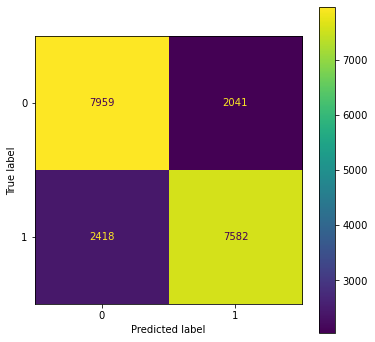

--- ROC AUC ---------------------------------------------------------------------------------------- 



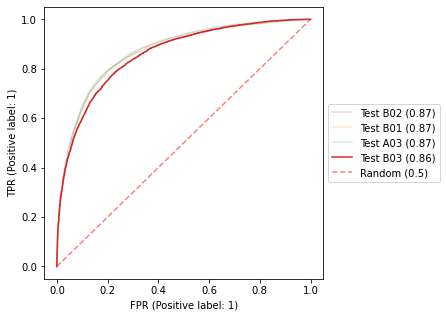

--- PRECISION RECALL AUC --------------------------------------------------------------------------- 



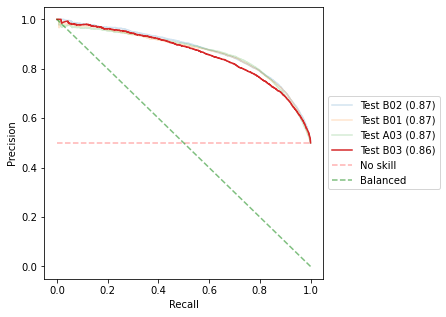

In [112]:
model_name = "Test B03"
get_scores(model_name, y_pred=y_preds, y_pred_proba=y_preds_proba, register=True, X_ref=X_test_ready, y_ref=y_test, training_time=train_time, inference_time=inf_time)

#### Compare

In [113]:
from classification_utils import scores_df
scores_df

,Method,threshold,params,ROC AUC,PR AUC,F1 score,Accuracy,Precision,Recall,TP,TN,FP,FN,Training time,Inference time
0,Test A00,None,None,0.510002,0.505938,0.339013,0.51315,0.527795,0.2497,2497,7766,2234,7503,7.679453,0.609395
1,Test A03,None,None,0.866633,0.866372,0.793137,0.79745,0.810393,0.7766,7766,8183,1817,2234,36.241583,1.581173
2,Test B01,None,None,0.868323,0.866994,0.790813,0.79415,0.803843,0.7782,7782,8101,1899,2218,29.195286,2.649221
3,Test B02,None,None,0.872496,0.873931,0.793764,0.79430,0.795838,0.7917,7917,7969,2031,2083,49.224950,3.653748
4,Test B03,None,None,0.858001,0.859934,0.772767,0.77705,0.787904,0.7582,7582,7959,2041,2418,94.840376,3.613615


In [114]:
sms.send("TestB03 Done", stop=False)

### Test B4 - RNN | Ngram=1 | int | Glove 100d Embedding + MASK + NOT Trainable

#### Standardize & Tokenize

In [115]:
max_length = 60
max_tokens = 20000

text_vectorizationB4 = TextVectorization(
    output_mode='int', # int, multi_hot, count, tf_idf
    max_tokens=max_tokens,
    ngrams=1,
    output_sequence_length=max_length # search the max size by default
)

In [116]:
text_vectorizationB4.adapt(list(data_work.text),True)

In [117]:
print(text_vectorizationB4.get_vocabulary()[:20], "...")

['', '[UNK]', 'i', 'be', 'to', 'the', 'a', 'not', 'my', 'and', 'it', 'you', 'have', 'do', 'for', 'in', 'go', 'of', 'that', 'get'] ...


#### Prepare dataset

In [118]:
X_train_ready = text_vectorizationB4(X_train)
X_test_ready = text_vectorizationB4(X_test)

In [119]:
X_train[:2]

164240          sit in bed where I will be for the weekend .
1084963    home sweet home , back from a great saturday a...
Name: text, dtype: object

In [120]:
X_train_ready[:2]

<tf.Tensor: shape=(2, 60), dtype=int64, numpy=
array([[  268,    15,   131,   201,     2,    29,     3,    14,     5,
          142,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0],
       [   78,   348,    78,    57,    58,     6,    90,   397,     9,
          300,    25, 19669,     1,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0]]

#### Embedding

In [121]:
embeddings_index = load_trained_glove("glove.6B.100d")

Loading from gZip: /home/jovyan/workspace/OC_AI_07/data/embedding_models/glove.6B.100d.gz


In [122]:
embedding_dim = 100
vocabulary = text_vectorizationB4.get_vocabulary()
embedding_matrix = convert_embedding_matrix(vocabulary, embeddings_index, max_tokens, embedding_dim)
embedding_matrix

Converted 16051 words, and couldn't find 3949 words
Missing words: ['', '[UNK]', 'hahaha', 'lmao', 'congrat', 'bday', 'followfriday', 'idk', 'hahah', 'itune', 'gutte', 'tweep', 'gunna', 'Ã¢Â\x99', 'Â«', 'hahahaha', 'thanx', 'Ã¢Â\x99Â¥', 'ughh', 'hehehe', '2morrow', 'squarespace', 'soooooo', 'Â°', 'wwwtweeteraddercom', 'ahaha', 'Â©', 'bestie', 'booo', 'sux', 'gnight', 'tmrw', 'ughhh', 'youu', 'prolly', 'heyy', 'boooo', 'goood', 'retweet', 'hayfever', 'youuu', 'thnx', 'wwwtweeterfollowcom', 'tweeple', 'sooooooo', 'lolz', '2moro', 'tomorow', 'lvatt', 'iranelection', 'hahahah', 'damnit', 'yeahh', 'urgh', 'tooo', 'rofl', 'meee', 'xox', 'bleh', 'awh', 'twitterverse', 'omfg', 'iÃ¢Â´m', 'yey', 'wrk', 'Ã¯Â¿Â½', 'itÃ¢Â´s', 'yess', 'yaaay', 'twitterer', 'musicmonday', 'gnite', 'effin', 'yayyy', 'twitterland', 'toooo', 'nkotb', 'iÃ¯Â¿Â½m', 'havnt', 'hahahahaha', 'Â¦', 'listenin', 'gooood', 'every1', 'bestfriend', 'awwwww', 'awsome', 'yayy', 'twitterberry', 'tshirt', 'tbh', 'srsly', 'retweete', 'hu

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.046539  ,  0.61966002,  0.56647003, ..., -0.37616   ,
        -0.032502  ,  0.80620003],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.29874   ,  0.24609999,  0.062514  , ...,  0.39331999,
        -0.51459002,  0.21692   ]])

In [123]:
# Embedding avec masque
embedding_layer = layers.Embedding(
    input_dim=max_tokens,
    output_dim=embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    # input_length=max_length,
    mask_zero=True,
    trainable=False, # <== default is True
)

#### Train model

In [124]:
model = architecture002("adam", "binary_crossentropy", ['accuracy'], embedding_layer)

In [125]:
model.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, None)]            0         
_________________________________________________________________
embedding_3 (Embedding)      (None, None, 100)         2000000   
_________________________________________________________________
bidirectional_3 (Bidirection (None, 64)                34048     
_________________________________________________________________
dropout_5 (Dropout)          (None, 64)                0         
_________________________________________________________________
predictions (Dense)          (None, 1)                 65        
Total params: 2,034,113
Trainable params: 34,113
Non-trainable params: 2,000,000
_________________________________________________________________


In [126]:
t0 = time.perf_counter()
history = model.fit(
        x=X_train_ready, y=y_train, 
        validation_data=(X_test_ready, y_test), 
        epochs=50, 
        batch_size=batch_size, 
        callbacks=init_callbacks2(f"MINI_TESTS_B04"),
        verbose=1,
)
train_time = time.perf_counter() - t0

Epoch 1/50
79/79 [==============================] - 9s 57ms/step - loss: 0.6826 - accuracy: 0.5617 - val_loss: 0.5811 - val_accuracy: 0.6980

Epoch 00001: val_accuracy improved from -inf to 0.69795, saving model to models/MINI_TESTS_B04.keras
Epoch 2/50
79/79 [==============================] - 3s 35ms/step - loss: 0.5770 - accuracy: 0.7008 - val_loss: 0.5557 - val_accuracy: 0.7153

Epoch 00002: val_accuracy improved from 0.69795 to 0.71535, saving model to models/MINI_TESTS_B04.keras
Epoch 3/50
79/79 [==============================] - 3s 35ms/step - loss: 0.5501 - accuracy: 0.7209 - val_loss: 0.5275 - val_accuracy: 0.7350

Epoch 00003: val_accuracy improved from 0.71535 to 0.73495, saving model to models/MINI_TESTS_B04.keras
Epoch 4/50
79/79 [==============================] - 3s 35ms/step - loss: 0.5297 - accuracy: 0.7359 - val_loss: 0.5169 - val_accuracy: 0.7434

Epoch 00004: val_accuracy improved from 0.73495 to 0.74345, saving model to models/MINI_TESTS_B04.keras
Epoch 5/50
79/79 [=

#### Evaluate

In [127]:
model = keras.models.load_model("models/MINI_TESTS_B04.keras")

In [128]:
model.evaluate(X_test_ready, y_test)

625/625 [==============================] - 3s 3ms/step - loss: 0.4690 - accuracy: 0.7784


[0.46895214915275574, 0.7784000039100647]

In [129]:
raw_txt = tf.convert_to_tensor(["I hate it", "I love it"])
raw_txt = text_vectorizationB4(raw_txt)
model.predict(raw_txt)

array([[0.12932946],
       [0.9341916 ]], dtype=float32)

In [130]:
t0 = time.perf_counter()
raw_txt = tf.convert_to_tensor(X_test)
raw_txt = text_vectorizationB4(raw_txt)
y_preds_proba = model.predict(raw_txt)
y_preds = np.where(y_preds_proba > 0.5, 1,0)
inf_time = time.perf_counter() - t0

----------------------------------------------------------------------------------------------------
          These information are based on the best estimator of the above cross-validation           
----------------------------------------------------------------------------------------------------

--- Test B04 ---------------------------------------------------------------------------------------

             ROC_AUC : 0.8580
                  F1 : 0.7772
            ACCURACY : 0.7784
           PRECISION : 0.7814
              RECALL : 0.7731
   AVERAGE_PRECISION : 0.8596

       TRAINING-TIME : 81.0540
      INFERENCE-TIME : 3.2922

--- Classification Report -------------------------------------------------------------------------- 

                 precision    recall  f1-score   support

Prediction = 0       0.78      0.78      0.78     10000
Prediction = 1       0.78      0.77      0.78     10000

      accuracy                           0.78     20000
     macro avg       

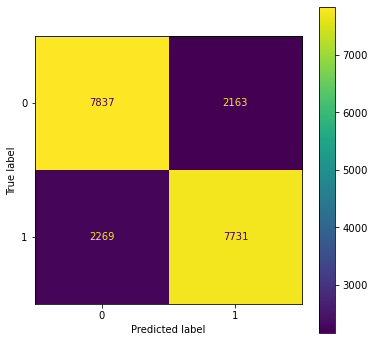

--- ROC AUC ---------------------------------------------------------------------------------------- 



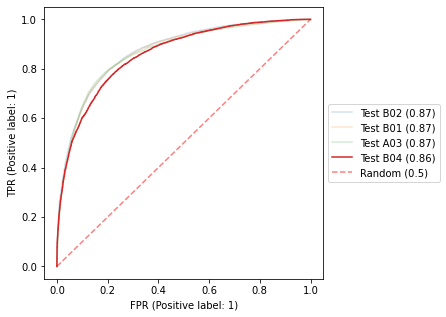

--- PRECISION RECALL AUC --------------------------------------------------------------------------- 



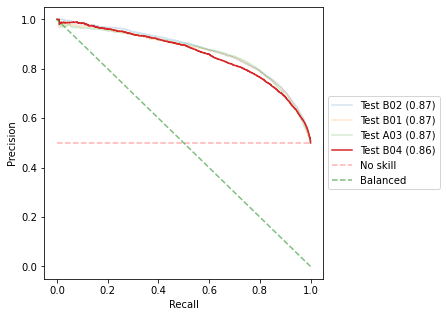

In [131]:
model_name = "Test B04"
get_scores(model_name, y_pred=y_preds, y_pred_proba=y_preds_proba, register=True, X_ref=X_test_ready, y_ref=y_test, training_time=train_time, inference_time=inf_time)

#### Compare

In [132]:
from classification_utils import scores_df
scores_df

,Method,threshold,params,ROC AUC,PR AUC,F1 score,Accuracy,Precision,Recall,TP,TN,FP,FN,Training time,Inference time
0,Test A00,None,None,0.510002,0.505938,0.339013,0.51315,0.527795,0.2497,2497,7766,2234,7503,7.679453,0.609395
1,Test A03,None,None,0.866633,0.866372,0.793137,0.79745,0.810393,0.7766,7766,8183,1817,2234,36.241583,1.581173
2,Test B01,None,None,0.868323,0.866994,0.790813,0.79415,0.803843,0.7782,7782,8101,1899,2218,29.195286,2.649221
3,Test B02,None,None,0.872496,0.873931,0.793764,0.79430,0.795838,0.7917,7917,7969,2031,2083,49.224950,3.653748
4,Test B03,None,None,0.858001,0.859934,0.772767,0.77705,0.787904,0.7582,7582,7959,2041,2418,94.840376,3.613615
5,Test B04,None,None,0.858031,0.859648,0.777219,0.77840,0.781383,0.7731,7731,7837,2163,2269,81.054028,3.292211


In [133]:
sms.send("TestB04 Done", stop=False)

### Test B5 - RNN | Ngram=1 | int | GloveTwitter25-gensim Embedding + MASK + NOT Trainable

#### Standardize & Tokenize

In [134]:
max_length = 60
max_tokens = 20000

text_vectorizationB5 = TextVectorization(
    output_mode='int', # int, multi_hot, count, tf_idf
    max_tokens=max_tokens,
    ngrams=1,
    output_sequence_length=max_length # search the max size by default
)

In [136]:
text_vectorizationB5.adapt(list(data_work.text), True)

In [137]:
print(text_vectorizationB5.get_vocabulary()[:20], "...")

['', '[UNK]', 'i', 'be', 'to', 'the', 'a', 'not', 'my', 'and', 'it', 'you', 'have', 'do', 'for', 'in', 'go', 'of', 'that', 'get'] ...


#### Prepare dataset

In [138]:
X_train_ready = text_vectorizationB5(X_train)
X_test_ready = text_vectorizationB5(X_test)

In [139]:
X_train[:2]

164240          sit in bed where I will be for the weekend .
1084963    home sweet home , back from a great saturday a...
Name: text, dtype: object

In [140]:
X_train_ready[:2]

<tf.Tensor: shape=(2, 60), dtype=int64, numpy=
array([[  268,    15,   131,   201,     2,    29,     3,    14,     5,
          142,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0],
       [   78,   348,    78,    57,    58,     6,    90,   397,     9,
          300,    25, 19669,     1,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0]]

#### Embedding

In [141]:
embeddings_index = load_gensim_embedding("glove-twitter-25")

Loading from /home/jovyan/workspace/OC_AI_07/data/embedding_models/glove-twitter-25.gz


In [142]:
embedding_dim = 25
vocabulary = text_vectorizationB5.get_vocabulary()
embedding_matrix = convert_embedding_matrix(vocabulary, embeddings_index, max_tokens, embedding_dim)
embedding_matrix

Converted 17511 words, and couldn't find 2489 words
Missing words: ['', '[UNK]', '2', '3', '4', '1', '5', '6', '10', '8', '7', '30', '100', '20', '12', '9', '1st', '15', '11', '2day', '2nd', '50', '25', 'Ã¢Â\x99', 'Â«', '16', 'b4', '18', '2009', '3rd', '17', 'Ã¢Â\x99Â¥', '24', '13', '40', '21', '2morrow', '80', 'e3', '0', '14', '3d', 'Â°', '2nite', 'wwwtweeteraddercom', 'Â©', '140', '200', '90', 'booo', '33', '70', '09', '1000', 'ughhh', 'f1', '22', '4th', 'gr8', 'boooo', '6th', '500', 'youuu', 'wwwtweeterfollowcom', '21st', '60', 'ps3', '2moro', '19', 'lvatt', '45', '2010', '300', '9th', '5th', '333', '35', 'iÃ¢Â´m', '3gs', '400', '360', 'Ã¯Â¿Â½', 'spymaster', 'itÃ¢Â´s', '430', '7th', '630', '23', '18th', 'yayyy', 'toooo', 'iÃ¯Â¿Â½m', 'Â¦', 'ohhhh', 'mp3', '830', '2night', '26', 'o2', 'every1', '8th', '530', '32', '28', '15th', 'twitterberry', 'asot400', '99', '930', '55', '10th', 'mcflyforgermany', '29', '27', '1230', 'marsiscome', '13th', 'ewww', 'booooo', '730', '20th', 'youuuu', '

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.26078999,  0.59108001,  0.61622   , ...,  0.076869  ,
         0.22840001,  0.27579999],
       ...,
       [ 0.33238   ,  0.97724998,  0.33893001, ...,  0.91947001,
        -0.32697001, -0.47874999],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.11615   ,  0.004311  , -0.26707   , ...,  0.048804  ,
         0.44986001, -0.30335999]])

In [143]:
# Embedding avec masque
embedding_layer = layers.Embedding(
    input_dim=max_tokens,
    output_dim=embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    # input_length=max_length,
    mask_zero=True,
    trainable=False, # <== default is True
)

#### Train model

In [144]:
model = architecture002("adam", "binary_crossentropy", ['accuracy'], embedding_layer)

In [145]:
model.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, None)]            0         
_________________________________________________________________
embedding_4 (Embedding)      (None, None, 25)          500000    
_________________________________________________________________
bidirectional_4 (Bidirection (None, 64)                14848     
_________________________________________________________________
dropout_6 (Dropout)          (None, 64)                0         
_________________________________________________________________
predictions (Dense)          (None, 1)                 65        
Total params: 514,913
Trainable params: 14,913
Non-trainable params: 500,000
_________________________________________________________________


In [146]:
t0 = time.perf_counter()
history = model.fit(
        x=X_train_ready, y=y_train, 
        validation_data=(X_test_ready, y_test), 
        epochs=50, 
        batch_size=batch_size, 
        callbacks=init_callbacks2(f"MINI_TESTS_B05"),
        verbose=1,
)
train_time = time.perf_counter() - t0

Epoch 1/50
79/79 [==============================] - 8s 42ms/step - loss: 0.6784 - accuracy: 0.5717 - val_loss: 0.6044 - val_accuracy: 0.6692

Epoch 00001: val_accuracy improved from -inf to 0.66920, saving model to models/MINI_TESTS_B05.keras
Epoch 2/50
79/79 [==============================] - 2s 21ms/step - loss: 0.6037 - accuracy: 0.6708 - val_loss: 0.5864 - val_accuracy: 0.6854

Epoch 00002: val_accuracy improved from 0.66920 to 0.68535, saving model to models/MINI_TESTS_B05.keras
Epoch 3/50
79/79 [==============================] - 2s 21ms/step - loss: 0.5926 - accuracy: 0.6819 - val_loss: 0.5760 - val_accuracy: 0.6943

Epoch 00003: val_accuracy improved from 0.68535 to 0.69430, saving model to models/MINI_TESTS_B05.keras
Epoch 4/50
79/79 [==============================] - 2s 21ms/step - loss: 0.5757 - accuracy: 0.6966 - val_loss: 0.5682 - val_accuracy: 0.6995

Epoch 00004: val_accuracy improved from 0.69430 to 0.69955, saving model to models/MINI_TESTS_B05.keras
Epoch 5/50
79/79 [=

#### Evaluate

In [147]:
model = keras.models.load_model("models/MINI_TESTS_B05.keras")

In [148]:
model.evaluate(X_test_ready, y_test)

625/625 [==============================] - 3s 3ms/step - loss: 0.4956 - accuracy: 0.7572


[0.49556025862693787, 0.7572000026702881]

In [149]:
raw_txt = tf.convert_to_tensor(["I hate it", "I love it"])
raw_txt = text_vectorizationB5(raw_txt)
model.predict(raw_txt)

array([[0.08785575],
       [0.8228073 ]], dtype=float32)

In [150]:
t0 = time.perf_counter()
raw_txt = tf.convert_to_tensor(X_test)
raw_txt = text_vectorizationB5(raw_txt)
y_preds_proba = model.predict(raw_txt)
y_preds = np.where(y_preds_proba > 0.5, 1,0)
inf_time = time.perf_counter() - t0

----------------------------------------------------------------------------------------------------
          These information are based on the best estimator of the above cross-validation           
----------------------------------------------------------------------------------------------------

--- Test B05 ---------------------------------------------------------------------------------------

             ROC_AUC : 0.8394
                  F1 : 0.7602
            ACCURACY : 0.7572
           PRECISION : 0.7509
              RECALL : 0.7697
   AVERAGE_PRECISION : 0.8405

       TRAINING-TIME : 49.1272
      INFERENCE-TIME : 3.1597

--- Classification Report -------------------------------------------------------------------------- 

                 precision    recall  f1-score   support

Prediction = 0       0.76      0.74      0.75     10000
Prediction = 1       0.75      0.77      0.76     10000

      accuracy                           0.76     20000
     macro avg       

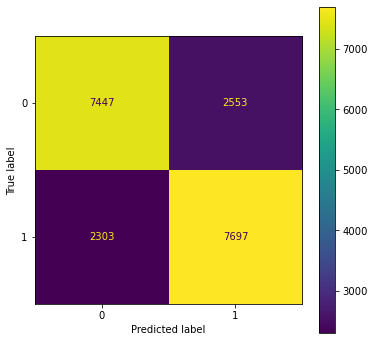

--- ROC AUC ---------------------------------------------------------------------------------------- 



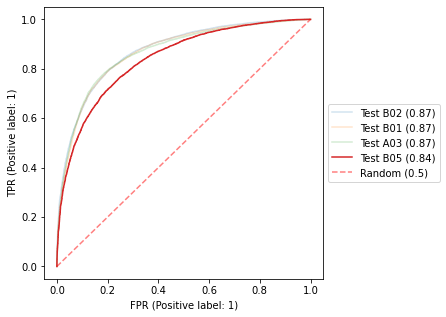

--- PRECISION RECALL AUC --------------------------------------------------------------------------- 



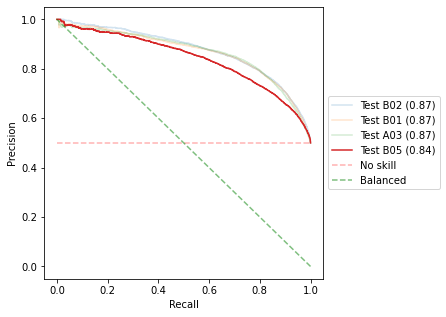

In [151]:
model_name = "Test B05"
get_scores(model_name, y_pred=y_preds, y_pred_proba=y_preds_proba, register=True, X_ref=X_test_ready, y_ref=y_test, training_time=train_time, inference_time=inf_time)

#### Compare

In [152]:
from classification_utils import scores_df
scores_df

,Method,threshold,params,ROC AUC,PR AUC,F1 score,Accuracy,Precision,Recall,TP,TN,FP,FN,Training time,Inference time
0,Test A00,None,None,0.510002,0.505938,0.339013,0.51315,0.527795,0.2497,2497,7766,2234,7503,7.679453,0.609395
1,Test A03,None,None,0.866633,0.866372,0.793137,0.79745,0.810393,0.7766,7766,8183,1817,2234,36.241583,1.581173
2,Test B01,None,None,0.868323,0.866994,0.790813,0.79415,0.803843,0.7782,7782,8101,1899,2218,29.195286,2.649221
3,Test B02,None,None,0.872496,0.873931,0.793764,0.79430,0.795838,0.7917,7917,7969,2031,2083,49.224950,3.653748
4,Test B03,None,None,0.858001,0.859934,0.772767,0.77705,0.787904,0.7582,7582,7959,2041,2418,94.840376,3.613615
5,Test B04,None,None,0.858031,0.859648,0.777219,0.77840,0.781383,0.7731,7731,7837,2163,2269,81.054028,3.292211
6,Test B05,None,None,0.839388,0.840457,0.760198,0.75720,0.750927,0.7697,7697,7447,2553,2303,49.127228,3.159663


In [153]:
sms.send("TestB05 Done", stop=False)

### Test B6 - RNN | Ngram=1 | int | GloveTwitter100-gensim Embedding + MASK + NOT Trainable

#### Standardize & Tokenize

In [154]:
max_length = 60
max_tokens = 20000

text_vectorizationB6 = TextVectorization(
    output_mode='int', # int, multi_hot, count, tf_idf
    max_tokens=max_tokens,
    ngrams=1,
    output_sequence_length=max_length # search the max size by default
)

In [155]:
text_vectorizationB6.adapt(list(data_work.text), True)

In [156]:
print(text_vectorizationB6.get_vocabulary()[:20], "...")

['', '[UNK]', 'i', 'be', 'to', 'the', 'a', 'not', 'my', 'and', 'it', 'you', 'have', 'do', 'for', 'in', 'go', 'of', 'that', 'get'] ...


#### Prepare dataset

In [157]:
X_train_ready = text_vectorizationB6(X_train)
X_test_ready = text_vectorizationB6(X_test)

In [158]:
X_train[:2]

164240          sit in bed where I will be for the weekend .
1084963    home sweet home , back from a great saturday a...
Name: text, dtype: object

In [159]:
X_train_ready[:2]

<tf.Tensor: shape=(2, 60), dtype=int64, numpy=
array([[  268,    15,   131,   201,     2,    29,     3,    14,     5,
          142,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0],
       [   78,   348,    78,    57,    58,     6,    90,   397,     9,
          300,    25, 19669,     1,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0]]

#### Embedding

In [160]:
embeddings_index = load_gensim_embedding("glove-twitter-100")

Loading from /home/jovyan/workspace/OC_AI_07/data/embedding_models/glove-twitter-100.gz


In [161]:
embedding_dim = 100
vocabulary = text_vectorizationB6.get_vocabulary()
embedding_matrix = convert_embedding_matrix(vocabulary, embeddings_index, max_tokens, embedding_dim)
embedding_matrix

Converted 17511 words, and couldn't find 2489 words
Missing words: ['', '[UNK]', '2', '3', '4', '1', '5', '6', '10', '8', '7', '30', '100', '20', '12', '9', '1st', '15', '11', '2day', '2nd', '50', '25', 'Ã¢Â\x99', 'Â«', '16', 'b4', '18', '2009', '3rd', '17', 'Ã¢Â\x99Â¥', '24', '13', '40', '21', '2morrow', '80', 'e3', '0', '14', '3d', 'Â°', '2nite', 'wwwtweeteraddercom', 'Â©', '140', '200', '90', 'booo', '33', '70', '09', '1000', 'ughhh', 'f1', '22', '4th', 'gr8', 'boooo', '6th', '500', 'youuu', 'wwwtweeterfollowcom', '21st', '60', 'ps3', '2moro', '19', 'lvatt', '45', '2010', '300', '9th', '5th', '333', '35', 'iÃ¢Â´m', '3gs', '400', '360', 'Ã¯Â¿Â½', 'spymaster', 'itÃ¢Â´s', '430', '7th', '630', '23', '18th', 'yayyy', 'toooo', 'iÃ¯Â¿Â½m', 'Â¦', 'ohhhh', 'mp3', '830', '2night', '26', 'o2', 'every1', '8th', '530', '32', '28', '15th', 'twitterberry', 'asot400', '99', '930', '55', '10th', 'mcflyforgermany', '29', '27', '1230', 'marsiscome', '13th', 'ewww', 'booooo', '730', '20th', 'youuuu', '

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-3.96210002e-04,  4.56699997e-01,  3.38900000e-01, ...,
        -4.29100007e-01,  1.07459998e+00, -3.65500003e-01],
       ...,
       [-3.11760008e-01, -6.01119995e-01, -7.06110001e-01, ...,
         4.73870009e-01,  2.89350003e-01,  2.46649995e-01],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 2.26779997e-01, -3.51490006e-02,  2.76549995e-01, ...,
         2.95940012e-01,  5.91589987e-01,  3.60040009e-01]])

In [162]:
# Embedding avec masque
embedding_layer = layers.Embedding(
    input_dim=max_tokens,
    output_dim=embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    # input_length=max_length,
    mask_zero=True,
    trainable=False, # <== default is True
)

#### Train model

In [163]:
model = architecture002("adam", "binary_crossentropy", ['accuracy'], embedding_layer)

In [164]:
model.summary()

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, None)]            0         
_________________________________________________________________
embedding_5 (Embedding)      (None, None, 100)         2000000   
_________________________________________________________________
bidirectional_5 (Bidirection (None, 64)                34048     
_________________________________________________________________
dropout_7 (Dropout)          (None, 64)                0         
_________________________________________________________________
predictions (Dense)          (None, 1)                 65        
Total params: 2,034,113
Trainable params: 34,113
Non-trainable params: 2,000,000
_________________________________________________________________


In [165]:
t0 = time.perf_counter()
history = model.fit(
        x=X_train_ready, y=y_train, 
        validation_data=(X_test_ready, y_test), 
        epochs=50, 
        batch_size=batch_size, 
        callbacks=init_callbacks2(f"MINI_TESTS_B06"),
        verbose=1,
)
train_time = time.perf_counter() - t0

Epoch 1/50
79/79 [==============================] - 10s 57ms/step - loss: 0.6520 - accuracy: 0.6007 - val_loss: 0.5301 - val_accuracy: 0.7368

Epoch 00001: val_accuracy improved from -inf to 0.73680, saving model to models/MINI_TESTS_B06.keras
Epoch 2/50
79/79 [==============================] - 3s 35ms/step - loss: 0.5275 - accuracy: 0.7381 - val_loss: 0.5056 - val_accuracy: 0.7531

Epoch 00002: val_accuracy improved from 0.73680 to 0.75315, saving model to models/MINI_TESTS_B06.keras
Epoch 3/50
79/79 [==============================] - 3s 35ms/step - loss: 0.5050 - accuracy: 0.7521 - val_loss: 0.4839 - val_accuracy: 0.7663

Epoch 00003: val_accuracy improved from 0.75315 to 0.76625, saving model to models/MINI_TESTS_B06.keras
Epoch 4/50
79/79 [==============================] - 3s 35ms/step - loss: 0.4847 - accuracy: 0.7653 - val_loss: 0.4790 - val_accuracy: 0.7686

Epoch 00004: val_accuracy improved from 0.76625 to 0.76860, saving model to models/MINI_TESTS_B06.keras
Epoch 5/50
79/79 [

#### Evaluate

In [166]:
model = keras.models.load_model("models/MINI_TESTS_B06.keras")

In [167]:
model.evaluate(X_test_ready, y_test)

625/625 [==============================] - 3s 3ms/step - loss: 0.4414 - accuracy: 0.7937


[0.4413509666919708, 0.7936999797821045]

In [168]:
raw_txt = tf.convert_to_tensor(["I hate it", "I love it"])
raw_txt = text_vectorizationB6(raw_txt)
model.predict(raw_txt)

array([[0.04903412],
       [0.93555105]], dtype=float32)

In [169]:
t0 = time.perf_counter()
raw_txt = tf.convert_to_tensor(X_test)
raw_txt = text_vectorizationB6(raw_txt)
y_preds_proba = model.predict(raw_txt)
y_preds = np.where(y_preds_proba > 0.5, 1,0)
inf_time = time.perf_counter() - t0

----------------------------------------------------------------------------------------------------
          These information are based on the best estimator of the above cross-validation           
----------------------------------------------------------------------------------------------------

--- Test B06 ---------------------------------------------------------------------------------------

             ROC_AUC : 0.8761
                  F1 : 0.7908
            ACCURACY : 0.7937
           PRECISION : 0.8022
              RECALL : 0.7797
   AVERAGE_PRECISION : 0.8783

       TRAINING-TIME : 71.7650
      INFERENCE-TIME : 3.2672

--- Classification Report -------------------------------------------------------------------------- 

                 precision    recall  f1-score   support

Prediction = 0       0.79      0.81      0.80     10000
Prediction = 1       0.80      0.78      0.79     10000

      accuracy                           0.79     20000
     macro avg       

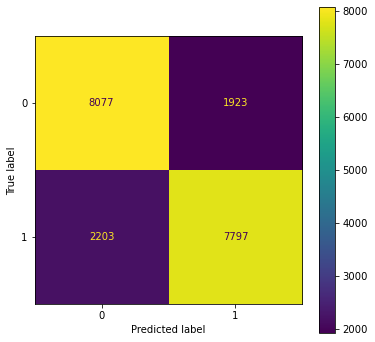

--- ROC AUC ---------------------------------------------------------------------------------------- 



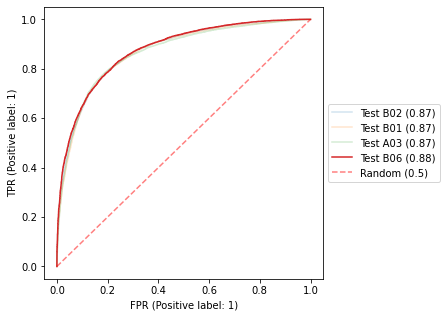

--- PRECISION RECALL AUC --------------------------------------------------------------------------- 



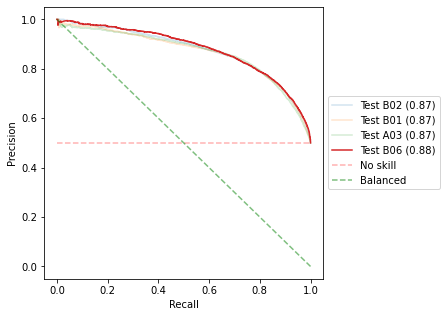

In [170]:
model_name = "Test B06"
get_scores(model_name, y_pred=y_preds, y_pred_proba=y_preds_proba, register=True, X_ref=X_test_ready, y_ref=y_test, training_time=train_time, inference_time=inf_time)

#### Compare

In [171]:
from classification_utils import scores_df
scores_df

,Method,threshold,params,ROC AUC,PR AUC,F1 score,Accuracy,Precision,Recall,TP,TN,FP,FN,Training time,Inference time
0,Test A00,None,None,0.510002,0.505938,0.339013,0.51315,0.527795,0.2497,2497,7766,2234,7503,7.679453,0.609395
1,Test A03,None,None,0.866633,0.866372,0.793137,0.79745,0.810393,0.7766,7766,8183,1817,2234,36.241583,1.581173
2,Test B01,None,None,0.868323,0.866994,0.790813,0.79415,0.803843,0.7782,7782,8101,1899,2218,29.195286,2.649221
3,Test B02,None,None,0.872496,0.873931,0.793764,0.79430,0.795838,0.7917,7917,7969,2031,2083,49.224950,3.653748
4,Test B03,None,None,0.858001,0.859934,0.772767,0.77705,0.787904,0.7582,7582,7959,2041,2418,94.840376,3.613615
5,Test B04,None,None,0.858031,0.859648,0.777219,0.77840,0.781383,0.7731,7731,7837,2163,2269,81.054028,3.292211
6,Test B05,None,None,0.839388,0.840457,0.760198,0.75720,0.750927,0.7697,7697,7447,2553,2303,49.127228,3.159663
7,Test B06,None,None,0.876113,0.878281,0.790771,0.79370,0.802160,0.7797,7797,8077,1923,2203,71.764973,3.267204


In [172]:
sms.send("TestB06 Done", stop=False)

### Test B7 - RNN | Ngram=1 | int | GloveTwitter200-gensim Embedding + MASK + NOT Trainable

#### Standardize & Tokenize

In [173]:
max_length = 60
max_tokens = 20000

text_vectorizationB7 = TextVectorization(
    output_mode='int', # int, multi_hot, count, tf_idf
    max_tokens=max_tokens,
    ngrams=1,
    output_sequence_length=max_length # search the max size by default
)

In [174]:
text_vectorizationB7.adapt(list(data_work.text), True)

In [175]:
print(text_vectorizationB7.get_vocabulary()[:20], "...")

['', '[UNK]', 'i', 'be', 'to', 'the', 'a', 'not', 'my', 'and', 'it', 'you', 'have', 'do', 'for', 'in', 'go', 'of', 'that', 'get'] ...


#### Prepare dataset

In [176]:
X_train_ready = text_vectorizationB7(X_train)
X_test_ready = text_vectorizationB7(X_test)

In [177]:
X_train[:2]

164240          sit in bed where I will be for the weekend .
1084963    home sweet home , back from a great saturday a...
Name: text, dtype: object

In [178]:
X_train_ready[:2]

<tf.Tensor: shape=(2, 60), dtype=int64, numpy=
array([[  268,    15,   131,   201,     2,    29,     3,    14,     5,
          142,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0],
       [   78,   348,    78,    57,    58,     6,    90,   397,     9,
          300,    25, 19669,     1,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0]]

#### Embedding

In [179]:
embeddings_index = load_gensim_embedding("glove-twitter-200")

Loading from /home/jovyan/workspace/OC_AI_07/data/embedding_models/glove-twitter-200.gz


In [180]:
embedding_dim = 200
vocabulary = text_vectorizationB7.get_vocabulary()
embedding_matrix = convert_embedding_matrix(vocabulary, embeddings_index, max_tokens, embedding_dim)
embedding_matrix

Converted 17511 words, and couldn't find 2489 words
Missing words: ['', '[UNK]', '2', '3', '4', '1', '5', '6', '10', '8', '7', '30', '100', '20', '12', '9', '1st', '15', '11', '2day', '2nd', '50', '25', 'Ã¢Â\x99', 'Â«', '16', 'b4', '18', '2009', '3rd', '17', 'Ã¢Â\x99Â¥', '24', '13', '40', '21', '2morrow', '80', 'e3', '0', '14', '3d', 'Â°', '2nite', 'wwwtweeteraddercom', 'Â©', '140', '200', '90', 'booo', '33', '70', '09', '1000', 'ughhh', 'f1', '22', '4th', 'gr8', 'boooo', '6th', '500', 'youuu', 'wwwtweeterfollowcom', '21st', '60', 'ps3', '2moro', '19', 'lvatt', '45', '2010', '300', '9th', '5th', '333', '35', 'iÃ¢Â´m', '3gs', '400', '360', 'Ã¯Â¿Â½', 'spymaster', 'itÃ¢Â´s', '430', '7th', '630', '23', '18th', 'yayyy', 'toooo', 'iÃ¯Â¿Â½m', 'Â¦', 'ohhhh', 'mp3', '830', '2night', '26', 'o2', 'every1', '8th', '530', '32', '28', '15th', 'twitterberry', 'asot400', '99', '930', '55', '10th', 'mcflyforgermany', '29', '27', '1230', 'marsiscome', '13th', 'ewww', 'booooo', '730', '20th', 'youuuu', '

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.056404  ,  0.49535999,  0.18438999, ...,  0.63598001,
        -0.18880001, -0.035558  ],
       ...,
       [-0.096356  ,  1.2062    ,  0.23548   , ...,  0.94726998,
         0.16539   ,  0.028865  ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.21808   , -0.12392   ,  0.11099   , ...,  0.75081998,
        -0.15744001, -0.11758   ]])

In [181]:
# Embedding avec masque
embedding_layer = layers.Embedding(
    input_dim=max_tokens,
    output_dim=embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    # input_length=max_length,
    mask_zero=True,
    trainable=False, # <== default is True
)

#### Train model

In [182]:
model = architecture002("adam", "binary_crossentropy", ['accuracy'], embedding_layer)

In [183]:
model.summary()

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, None)]            0         
_________________________________________________________________
embedding_6 (Embedding)      (None, None, 200)         4000000   
_________________________________________________________________
bidirectional_6 (Bidirection (None, 64)                59648     
_________________________________________________________________
dropout_8 (Dropout)          (None, 64)                0         
_________________________________________________________________
predictions (Dense)          (None, 1)                 65        
Total params: 4,059,713
Trainable params: 59,713
Non-trainable params: 4,000,000
_________________________________________________________________


In [184]:
t0 = time.perf_counter()
history = model.fit(
        x=X_train_ready, y=y_train, 
        validation_data=(X_test_ready, y_test), 
        epochs=50, 
        batch_size=batch_size, 
        callbacks=init_callbacks2(f"MINI_TESTS_B07"),
        verbose=1,
)
train_time = time.perf_counter() - t0

Epoch 1/50
79/79 [==============================] - 12s 75ms/step - loss: 0.6313 - accuracy: 0.6305 - val_loss: 0.4999 - val_accuracy: 0.7563

Epoch 00001: val_accuracy improved from -inf to 0.75635, saving model to models/MINI_TESTS_B07.keras
Epoch 2/50
79/79 [==============================] - 4s 53ms/step - loss: 0.4998 - accuracy: 0.7595 - val_loss: 0.4812 - val_accuracy: 0.7689

Epoch 00002: val_accuracy improved from 0.75635 to 0.76890, saving model to models/MINI_TESTS_B07.keras
Epoch 3/50
79/79 [==============================] - 4s 54ms/step - loss: 0.4801 - accuracy: 0.7690 - val_loss: 0.4653 - val_accuracy: 0.7778

Epoch 00003: val_accuracy improved from 0.76890 to 0.77775, saving model to models/MINI_TESTS_B07.keras
Epoch 4/50
79/79 [==============================] - 4s 54ms/step - loss: 0.4611 - accuracy: 0.7810 - val_loss: 0.4634 - val_accuracy: 0.7768

Epoch 00004: val_accuracy did not improve from 0.77775
Epoch 5/50
79/79 [==============================] - 4s 54ms/step - 

#### Evaluate

In [185]:
model = keras.models.load_model("models/MINI_TESTS_B07.keras")

In [186]:
model.evaluate(X_test_ready, y_test)

625/625 [==============================] - 4s 4ms/step - loss: 0.4351 - accuracy: 0.7962


[0.43511533737182617, 0.7961999773979187]

In [187]:
raw_txt = tf.convert_to_tensor(["I hate it", "I love it"])
raw_txt = text_vectorizationB7(raw_txt)
model.predict(raw_txt)

array([[0.07592249],
       [0.95508057]], dtype=float32)

In [188]:
t0 = time.perf_counter()
raw_txt = tf.convert_to_tensor(X_test)
raw_txt = text_vectorizationB7(raw_txt)
y_preds_proba = model.predict(raw_txt)
y_preds = np.where(y_preds_proba > 0.5, 1,0)
inf_time = time.perf_counter() - t0

----------------------------------------------------------------------------------------------------
          These information are based on the best estimator of the above cross-validation           
----------------------------------------------------------------------------------------------------

--- Test B07 ---------------------------------------------------------------------------------------

             ROC_AUC : 0.8805
                  F1 : 0.7967
            ACCURACY : 0.7962
           PRECISION : 0.7946
              RECALL : 0.7989
   AVERAGE_PRECISION : 0.8817

       TRAINING-TIME : 93.3592
      INFERENCE-TIME : 3.3591

--- Classification Report -------------------------------------------------------------------------- 

                 precision    recall  f1-score   support

Prediction = 0       0.80      0.79      0.80     10000
Prediction = 1       0.79      0.80      0.80     10000

      accuracy                           0.80     20000
     macro avg       

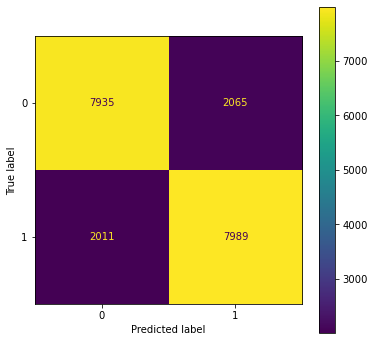

--- ROC AUC ---------------------------------------------------------------------------------------- 



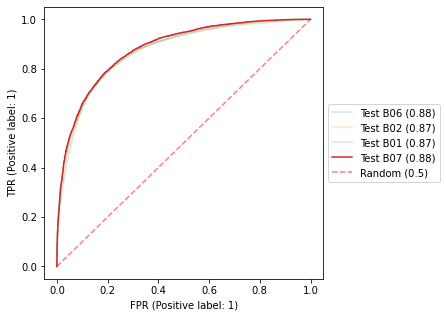

--- PRECISION RECALL AUC --------------------------------------------------------------------------- 



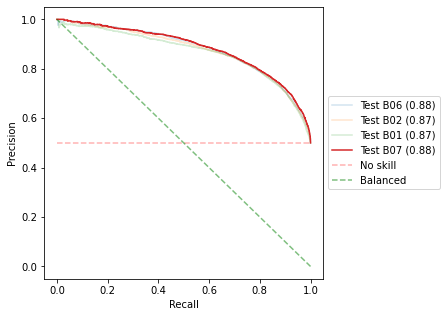

In [189]:
model_name = "Test B07"
get_scores(model_name, y_pred=y_preds, y_pred_proba=y_preds_proba, register=True, X_ref=X_test_ready, y_ref=y_test, training_time=train_time, inference_time=inf_time)

#### Compare

In [190]:
from classification_utils import scores_df
scores_df

,Method,threshold,params,ROC AUC,PR AUC,F1 score,Accuracy,Precision,Recall,TP,TN,FP,FN,Training time,Inference time
0,Test A00,None,None,0.510002,0.505938,0.339013,0.51315,0.527795,0.2497,2497,7766,2234,7503,7.679453,0.609395
1,Test A03,None,None,0.866633,0.866372,0.793137,0.79745,0.810393,0.7766,7766,8183,1817,2234,36.241583,1.581173
2,Test B01,None,None,0.868323,0.866994,0.790813,0.79415,0.803843,0.7782,7782,8101,1899,2218,29.195286,2.649221
3,Test B02,None,None,0.872496,0.873931,0.793764,0.79430,0.795838,0.7917,7917,7969,2031,2083,49.224950,3.653748
4,Test B03,None,None,0.858001,0.859934,0.772767,0.77705,0.787904,0.7582,7582,7959,2041,2418,94.840376,3.613615
5,Test B04,None,None,0.858031,0.859648,0.777219,0.77840,0.781383,0.7731,7731,7837,2163,2269,81.054028,3.292211
6,Test B05,None,None,0.839388,0.840457,0.760198,0.75720,0.750927,0.7697,7697,7447,2553,2303,49.127228,3.159663
7,Test B06,None,None,0.876113,0.878281,0.790771,0.79370,0.802160,0.7797,7797,8077,1923,2203,71.764973,3.267204
8,Test B07,None,None,0.880537,0.881681,0.796749,0.79620,0.794609,0.7989,7989,7935,2065,2011,93.359180,3.359108


In [191]:
sms.send("TestB07 Done", stop=False)

### Test B8 - RNN | Ngram=1 | int | FastText300-gensim Embedding + MASK + NOT Trainable

#### Standardize & Tokenize

In [192]:
max_length = 60
max_tokens = 20000

text_vectorizationB8 = TextVectorization(
    output_mode='int', # int, multi_hot, count, tf_idf
    max_tokens=max_tokens,
    ngrams=1,
    output_sequence_length=max_length # search the max size by default
)

In [194]:
text_vectorizationB8.adapt(list(data_work.text), True)

In [195]:
print(text_vectorizationB8.get_vocabulary()[:20], "...")

['', '[UNK]', 'i', 'be', 'to', 'the', 'a', 'not', 'my', 'and', 'it', 'you', 'have', 'do', 'for', 'in', 'go', 'of', 'that', 'get'] ...


#### Prepare dataset

In [196]:
X_train_ready = text_vectorizationB8(X_train)
X_test_ready = text_vectorizationB8(X_test)

In [197]:
X_train[:2]

164240          sit in bed where I will be for the weekend .
1084963    home sweet home , back from a great saturday a...
Name: text, dtype: object

In [198]:
X_train_ready[:2]

<tf.Tensor: shape=(2, 60), dtype=int64, numpy=
array([[  268,    15,   131,   201,     2,    29,     3,    14,     5,
          142,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0],
       [   78,   348,    78,    57,    58,     6,    90,   397,     9,
          300,    25, 19669,     1,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0]]

#### Embedding

In [199]:
embeddings_index = load_gensim_embedding("fasttext-wiki-news-subwords-300")

Loading from /home/jovyan/workspace/OC_AI_07/data/embedding_models/fasttext-wiki-news-subwords-300.gz


In [200]:
embedding_dim = 300
vocabulary = text_vectorizationB8.get_vocabulary()
embedding_matrix = convert_embedding_matrix(vocabulary, embeddings_index, max_tokens, embedding_dim)
embedding_matrix

Converted 16228 words, and couldn't find 3772 words
Missing words: ['', '[UNK]', 'followfriday', 'fml', 'itune', 'gutte', 'tweep', 'tweetdeck', 'Ã¢Â\x99', 'Â«', 'Ã¢Â\x99Â¥', 'squarespace', 'tweetie', 'Â°', 'wwwtweeteraddercom', 'Â©', 'gnight', 'wwwtweeterfollowcom', 'tweeple', 'lvatt', 'iranelection', 'yike', 'bsb', 'tgif', 'goodmorning', 'iÃ¢Â´m', '3gs', 'Ã¯Â¿Â½', 'itÃ¢Â´s', 'yaaay', 'musicmonday', 'gnite', 'yayyy', 'wwdc', 'twitterland', 'nkotb', 'iÃ¯Â¿Â½m', 'Â¦', 'plurk', 'yayy', 'twitterberry', 'retweete', 'farrah', 'asot400', 'mcflyforgermany', 'twitterville', 'marsiscome', 'wkend', 'goodnite', 'booooo', 'blogge', 'youuuu', 'wwwiamsoannoyedcom', 'twitt', 'itouch', 'goodmorne', 'delongeday', 'w00', 'twitterfon', 'poope', 'methink', 'dissapointe', 'Â¡', 'tomoz', 'sims3', 'seesmic', 'boooooo', 'blogtv', 'tomoro', 'spamme', 'noww', 'myweakness', 'musso', 'dmb', 'belate', 'babysitte', 'yaay', 'unfollowe', 'shoppin', 'owww', 'ooc', 'loveee', 'flylady', 'dayy', 'comicstrip', 'archuleta',

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.060418  ,  0.069955  ,  0.053173  , ..., -0.0047788 ,
         0.033832  , -0.20630001],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.01926   , -0.048273  , -0.028872  , ..., -0.011481  ,
         0.0012931 , -0.00035449]])

In [201]:
# Embedding avec masque
embedding_layer = layers.Embedding(
    input_dim=max_tokens,
    output_dim=embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    # input_length=max_length,
    mask_zero=True,
    trainable=False, # <== default is True
)

#### Train model

In [202]:
model = architecture002("adam", "binary_crossentropy", ['accuracy'], embedding_layer)

In [203]:
model.summary()

Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, None)]            0         
_________________________________________________________________
embedding_7 (Embedding)      (None, None, 300)         6000000   
_________________________________________________________________
bidirectional_7 (Bidirection (None, 64)                85248     
_________________________________________________________________
dropout_9 (Dropout)          (None, 64)                0         
_________________________________________________________________
predictions (Dense)          (None, 1)                 65        
Total params: 6,085,313
Trainable params: 85,313
Non-trainable params: 6,000,000
_________________________________________________________________


In [204]:
t0 = time.perf_counter()
history = model.fit(
        x=X_train_ready, y=y_train, 
        validation_data=(X_test_ready, y_test), 
        epochs=50, 
        batch_size=batch_size, 
        callbacks=init_callbacks2(f"MINI_TESTS_B08"),
        verbose=1,
)
train_time = time.perf_counter() - t0

Epoch 1/50
79/79 [==============================] - 13s 95ms/step - loss: 0.6648 - accuracy: 0.5913 - val_loss: 0.5685 - val_accuracy: 0.7246

Epoch 00001: val_accuracy improved from -inf to 0.72455, saving model to models/MINI_TESTS_B08.keras
Epoch 2/50
79/79 [==============================] - 6s 73ms/step - loss: 0.5572 - accuracy: 0.7294 - val_loss: 0.5326 - val_accuracy: 0.7441

Epoch 00002: val_accuracy improved from 0.72455 to 0.74415, saving model to models/MINI_TESTS_B08.keras
Epoch 3/50
79/79 [==============================] - 6s 73ms/step - loss: 0.5285 - accuracy: 0.7411 - val_loss: 0.5123 - val_accuracy: 0.7531

Epoch 00003: val_accuracy improved from 0.74415 to 0.75305, saving model to models/MINI_TESTS_B08.keras
Epoch 4/50
79/79 [==============================] - 6s 73ms/step - loss: 0.5102 - accuracy: 0.7542 - val_loss: 0.5204 - val_accuracy: 0.7462

Epoch 00004: val_accuracy did not improve from 0.75305
Epoch 5/50
79/79 [==============================] - 6s 73ms/step - 

#### Evaluate

In [205]:
model = keras.models.load_model("models/MINI_TESTS_B08.keras")

In [206]:
model.evaluate(X_test_ready, y_test)

625/625 [==============================] - 4s 4ms/step - loss: 0.4674 - accuracy: 0.7789


[0.4674137234687805, 0.7788500189781189]

In [207]:
raw_txt = tf.convert_to_tensor(["I hate it", "I love it"])
raw_txt = text_vectorizationB8(raw_txt)
model.predict(raw_txt)

array([[0.10389941],
       [0.92374706]], dtype=float32)

In [208]:
t0 = time.perf_counter()
raw_txt = tf.convert_to_tensor(X_test)
raw_txt = text_vectorizationB8(raw_txt)
y_preds_proba = model.predict(raw_txt)
y_preds = np.where(y_preds_proba > 0.5, 1,0)
inf_time = time.perf_counter() - t0

----------------------------------------------------------------------------------------------------
          These information are based on the best estimator of the above cross-validation           
----------------------------------------------------------------------------------------------------

--- Test B08 ---------------------------------------------------------------------------------------

             ROC_AUC : 0.8616
                  F1 : 0.7874
            ACCURACY : 0.7789
           PRECISION : 0.7581
              RECALL : 0.8190
   AVERAGE_PRECISION : 0.8627

       TRAINING-TIME : 156.3155
      INFERENCE-TIME : 4.0273

--- Classification Report -------------------------------------------------------------------------- 

                 precision    recall  f1-score   support

Prediction = 0       0.80      0.74      0.77     10000
Prediction = 1       0.76      0.82      0.79     10000

      accuracy                           0.78     20000
     macro avg      

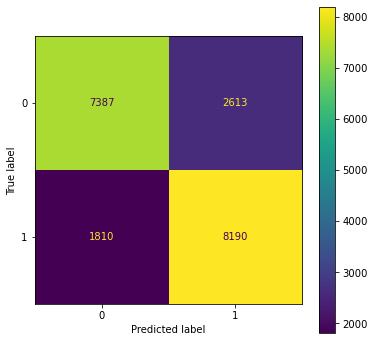

--- ROC AUC ---------------------------------------------------------------------------------------- 



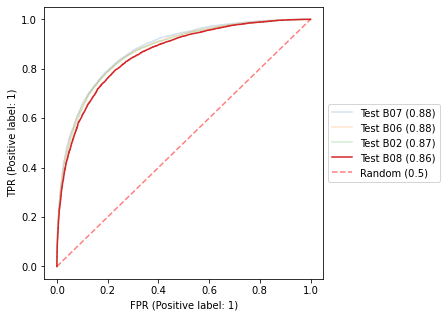

--- PRECISION RECALL AUC --------------------------------------------------------------------------- 



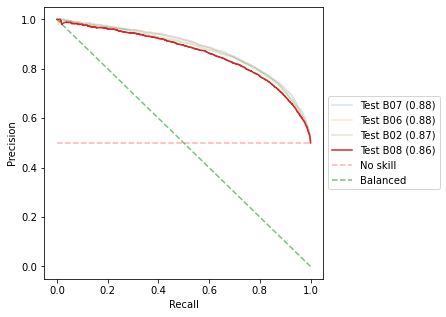

In [209]:
model_name = "Test B08"
get_scores(model_name, y_pred=y_preds, y_pred_proba=y_preds_proba, register=True, X_ref=X_test_ready, y_ref=y_test, training_time=train_time, inference_time=inf_time)

#### Compare

In [210]:
from classification_utils import scores_df
scores_df

,Method,threshold,params,ROC AUC,PR AUC,F1 score,Accuracy,Precision,Recall,TP,TN,FP,FN,Training time,Inference time
0,Test A00,None,None,0.510002,0.505938,0.339013,0.51315,0.527795,0.2497,2497,7766,2234,7503,7.679453,0.609395
1,Test A03,None,None,0.866633,0.866372,0.793137,0.79745,0.810393,0.7766,7766,8183,1817,2234,36.241583,1.581173
2,Test B01,None,None,0.868323,0.866994,0.790813,0.79415,0.803843,0.7782,7782,8101,1899,2218,29.195286,2.649221
3,Test B02,None,None,0.872496,0.873931,0.793764,0.79430,0.795838,0.7917,7917,7969,2031,2083,49.224950,3.653748
4,Test B03,None,None,0.858001,0.859934,0.772767,0.77705,0.787904,0.7582,7582,7959,2041,2418,94.840376,3.613615
5,Test B04,None,None,0.858031,0.859648,0.777219,0.77840,0.781383,0.7731,7731,7837,2163,2269,81.054028,3.292211
6,Test B05,None,None,0.839388,0.840457,0.760198,0.75720,0.750927,0.7697,7697,7447,2553,2303,49.127228,3.159663
7,Test B06,None,None,0.876113,0.878281,0.790771,0.79370,0.802160,0.7797,7797,8077,1923,2203,71.764973,3.267204
8,Test B07,None,None,0.880537,0.881681,0.796749,0.79620,0.794609,0.7989,7989,7935,2065,2011,93.359180,3.359108
9,Test B08,None,None,0.861583,0.862701,0.787386,0.77885,0.758123,0.8190,8190,7387,2613,1810,156.315505,4.027334


In [211]:
sms.send("TestB08 Done", stop=False)

### Test B9 - RNN | Ngram=1 | int | Word2Vec300Google-gensim Embedding + MASK + NOT Trainable

#### Standardize & Tokenize

In [212]:
max_length = 60
max_tokens = 20000

text_vectorizationB9 = TextVectorization(
    output_mode='int', # int, multi_hot, count, tf_idf
    max_tokens=max_tokens,
    ngrams=1,
    output_sequence_length=max_length # search the max size by default
)

In [216]:
text_vectorizationB9.adapt(list(data_work.text), True)

In [217]:
print(text_vectorizationB9.get_vocabulary()[:20], "...")

['', '[UNK]', 'i', 'be', 'to', 'the', 'a', 'not', 'my', 'and', 'it', 'you', 'have', 'do', 'for', 'in', 'go', 'of', 'that', 'get'] ...


#### Prepare dataset

In [218]:
X_train_ready = text_vectorizationB9(X_train)
X_test_ready = text_vectorizationB9(X_test)

In [219]:
X_train[:2]

164240          sit in bed where I will be for the weekend .
1084963    home sweet home , back from a great saturday a...
Name: text, dtype: object

In [220]:
X_train_ready[:2]

<tf.Tensor: shape=(2, 60), dtype=int64, numpy=
array([[  268,    15,   131,   201,     2,    29,     3,    14,     5,
          142,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0],
       [   78,   348,    78,    57,    58,     6,    90,   397,     9,
          300,    25, 19669,     1,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0]]

#### Embedding

In [221]:
embeddings_index = load_gensim_embedding("word2vec-google-news-300", binary=True)

Loading from /home/jovyan/workspace/OC_AI_07/data/embedding_models/word2vec-google-news-300.gz


In [222]:
embedding_dim = 300
vocabulary = text_vectorizationB9.get_vocabulary()
embedding_matrix = convert_embedding_matrix(vocabulary, embeddings_index, max_tokens, embedding_dim)
embedding_matrix

Converted 14910 words, and couldn't find 5090 words
Missing words: ['', '[UNK]', 'to', 'a', 'and', 'of', '10', '30', '100', '20', '12', 'followfriday', '15', '11', '50', 'itune', 'gutte', 'mcfly', '25', 'tweetdeck', 'starbuck', 'Ã¢Â\x99', 'favourite', 'Â«', '16', '18', '2009', 'realise', 'bgt', '17', 'Ã¢Â\x99Â¥', '24', '13', '40', '21', 'grey', '80', '14', 'squarespace', 'tweetie', 'Â°', 'wwwtweeteraddercom', 'Â©', '140', '200', '90', 'gnight', '33', '70', '09', 'jona', '1000', 'ughhh', 'colour', '22', 'heyy', '500', 'youuu', 'wwwtweeterfollowcom', '21st', '60', 'neighbour', '19', 'lvatt', 'iranelection', '45', '2010', 'yike', 'bsb', '300', 'yeahh', 'tgif', '333', 'goodmorning', 'awh', '35', 'tmr', 'iÃ¢Â´m', '400', '360', 'Ã¯Â¿Â½', 'theatre', 'mitchel', 'itÃ¢Â´s', 'arse', '430', 'yess', 'yaaay', 'musicmonday', 'gnite', '630', '23', '18th', 'yayyy', 'wwdc', 'twitterland', 'nkotb', 'iÃ¯Â¿Â½m', 'Â¦', 'plurk', 'paramore', '830', '26', '530', '32', '28', '15th', 'yayy', 'twitterberry', 'ret

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.22558594, -0.01953125,  0.09082031, ...,  0.02819824,
        -0.17773438, -0.00604248],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.11621094,  0.04174805, -0.07910156, ..., -0.06201172,
        -0.14160156,  0.05395508]])

In [223]:
# Embedding avec masque
embedding_layer = layers.Embedding(
    input_dim=max_tokens,
    output_dim=embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    # input_length=max_length,
    mask_zero=True,
    trainable=False, # <== default is True
)

#### Train model

In [224]:
model = architecture002("adam", "binary_crossentropy", ['accuracy'], embedding_layer)

In [225]:
model.summary()

Model: "model_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, None)]            0         
_________________________________________________________________
embedding_8 (Embedding)      (None, None, 300)         6000000   
_________________________________________________________________
bidirectional_8 (Bidirection (None, 64)                85248     
_________________________________________________________________
dropout_10 (Dropout)         (None, 64)                0         
_________________________________________________________________
predictions (Dense)          (None, 1)                 65        
Total params: 6,085,313
Trainable params: 85,313
Non-trainable params: 6,000,000
_________________________________________________________________


In [226]:
t0 = time.perf_counter()
history = model.fit(
        x=X_train_ready, y=y_train, 
        validation_data=(X_test_ready, y_test), 
        epochs=50, 
        batch_size=batch_size, 
        callbacks=init_callbacks2(f"MINI_TESTS_B09"),
        verbose=1,
)
train_time = time.perf_counter() - t0

Epoch 1/50
79/79 [==============================] - 13s 107ms/step - loss: 0.6419 - accuracy: 0.6249 - val_loss: 0.5314 - val_accuracy: 0.7408

Epoch 00001: val_accuracy improved from -inf to 0.74080, saving model to models/MINI_TESTS_B09.keras
Epoch 2/50
79/79 [==============================] - 6s 73ms/step - loss: 0.5237 - accuracy: 0.7454 - val_loss: 0.5094 - val_accuracy: 0.7531

Epoch 00002: val_accuracy improved from 0.74080 to 0.75315, saving model to models/MINI_TESTS_B09.keras
Epoch 3/50
79/79 [==============================] - 6s 73ms/step - loss: 0.5040 - accuracy: 0.7550 - val_loss: 0.4909 - val_accuracy: 0.7632

Epoch 00003: val_accuracy improved from 0.75315 to 0.76320, saving model to models/MINI_TESTS_B09.keras
Epoch 4/50
79/79 [==============================] - 6s 73ms/step - loss: 0.4873 - accuracy: 0.7680 - val_loss: 0.4855 - val_accuracy: 0.7668

Epoch 00004: val_accuracy improved from 0.76320 to 0.76685, saving model to models/MINI_TESTS_B09.keras
Epoch 5/50
79/79 

#### Evaluate

In [227]:
model = keras.models.load_model("models/MINI_TESTS_B09.keras")

In [228]:
model.evaluate(X_test_ready, y_test)

625/625 [==============================] - 4s 4ms/step - loss: 0.4566 - accuracy: 0.7868


[0.45657840371131897, 0.7868000268936157]

In [229]:
raw_txt = tf.convert_to_tensor(["I hate it", "I love it"])
raw_txt = text_vectorizationB9(raw_txt)
model.predict(raw_txt)

array([[0.07857778],
       [0.92902637]], dtype=float32)

In [230]:
t0 = time.perf_counter()
raw_txt = tf.convert_to_tensor(X_test)
raw_txt = text_vectorizationB9(raw_txt)
y_preds_proba = model.predict(raw_txt)
y_preds = np.where(y_preds_proba > 0.5, 1,0)
inf_time = time.perf_counter() - t0

----------------------------------------------------------------------------------------------------
          These information are based on the best estimator of the above cross-validation           
----------------------------------------------------------------------------------------------------

--- Test B09 ---------------------------------------------------------------------------------------

             ROC_AUC : 0.8675
                  F1 : 0.7885
            ACCURACY : 0.7868
           PRECISION : 0.7822
              RECALL : 0.7950
   AVERAGE_PRECISION : 0.8682

       TRAINING-TIME : 148.7075
      INFERENCE-TIME : 3.5920

--- Classification Report -------------------------------------------------------------------------- 

                 precision    recall  f1-score   support

Prediction = 0       0.79      0.78      0.79     10000
Prediction = 1       0.78      0.80      0.79     10000

      accuracy                           0.79     20000
     macro avg      

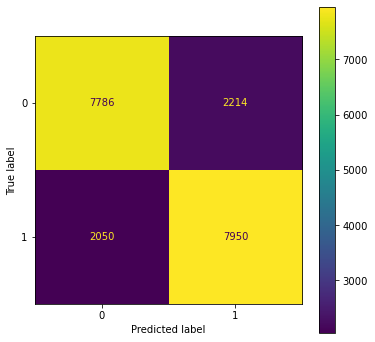

--- ROC AUC ---------------------------------------------------------------------------------------- 



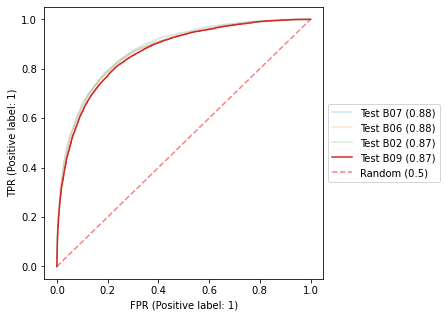

--- PRECISION RECALL AUC --------------------------------------------------------------------------- 



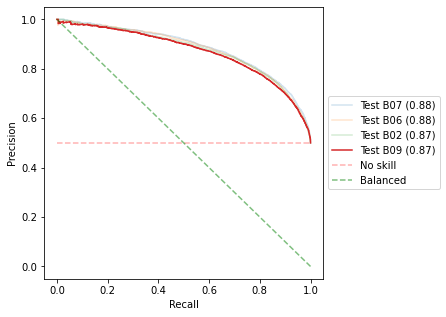

In [231]:
model_name = "Test B09"
get_scores(model_name, y_pred=y_preds, y_pred_proba=y_preds_proba, register=True, X_ref=X_test_ready, y_ref=y_test, training_time=train_time, inference_time=inf_time)

#### Compare

In [232]:
from classification_utils import scores_df
scores_df

,Method,threshold,params,ROC AUC,PR AUC,F1 score,Accuracy,Precision,Recall,TP,TN,FP,FN,Training time,Inference time
0,Test A00,None,None,0.510002,0.505938,0.339013,0.51315,0.527795,0.2497,2497,7766,2234,7503,7.679453,0.609395
1,Test A03,None,None,0.866633,0.866372,0.793137,0.79745,0.810393,0.7766,7766,8183,1817,2234,36.241583,1.581173
2,Test B01,None,None,0.868323,0.866994,0.790813,0.79415,0.803843,0.7782,7782,8101,1899,2218,29.195286,2.649221
3,Test B02,None,None,0.872496,0.873931,0.793764,0.79430,0.795838,0.7917,7917,7969,2031,2083,49.224950,3.653748
4,Test B03,None,None,0.858001,0.859934,0.772767,0.77705,0.787904,0.7582,7582,7959,2041,2418,94.840376,3.613615
5,Test B04,None,None,0.858031,0.859648,0.777219,0.77840,0.781383,0.7731,7731,7837,2163,2269,81.054028,3.292211
6,Test B05,None,None,0.839388,0.840457,0.760198,0.75720,0.750927,0.7697,7697,7447,2553,2303,49.127228,3.159663
7,Test B06,None,None,0.876113,0.878281,0.790771,0.79370,0.802160,0.7797,7797,8077,1923,2203,71.764973,3.267204
8,Test B07,None,None,0.880537,0.881681,0.796749,0.79620,0.794609,0.7989,7989,7935,2065,2011,93.359180,3.359108
9,Test B08,None,None,0.861583,0.862701,0.787386,0.77885,0.758123,0.8190,8190,7387,2613,1810,156.315505,4.027334


In [233]:
sms.send("TestB09 Done", stop=False)

## Ref Algo classique

### Test C0 - LogisticRegression | RAW_lemmas_not_filtered (comme les autres)

In [237]:
from sklearn.model_selection import StratifiedKFold

skfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_seed)

#### Préparons le jeu de données en `Train` et `Test` sets

In [238]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Prepare TF-IDF 
tfidf_vectorizer_train = TfidfVectorizer(use_idf=True, min_df=5, max_df=0.5) #, max_features=2000)
X_train_ready = tfidf_vectorizer_train.fit_transform(X_train)
X_test_ready = tfidf_vectorizer_train.transform(X_test)

In [239]:
print(f"TF-IDF features: {tfidf_vectorizer_train.get_feature_names_out()}")
print(f"Sets shapes >> X_train_ready: {X_train_ready.shape}, X_test_ready: {X_test_ready.shape}")

TF-IDF features: ['00' '000' '01' ... 'â½ã' 'â¾' 'â¾ã']
Sets shapes >> X_train_ready: (80000, 7980), X_test_ready: (20000, 7980)


#### Appliquons la Logistic Regression avec ce jeu de données

In [240]:
from sklearn.linear_model import LogisticRegression
from scipy.stats import uniform, loguniform

In [241]:
max_lr_iter = 3000
param_grid = [
    {
        'random_state':[random_seed],
        'max_iter':[max_lr_iter],
        'solver' : ['lbfgs'],
        'penalty' : ['l2'], # none
        'C' : loguniform(1e-5, 1e2),
    },
    {
        'random_state':[random_seed],
        'max_iter':[max_lr_iter],
        'solver' : ['liblinear'],
        'penalty' : ['l1', 'l2'], # none
        'C' : loguniform(1e-5, 1e2),
    },
    {
        'random_state':[random_seed],
        'max_iter':[max_lr_iter],
        'solver' : ['saga'],
        'penalty' : ['elasticnet'], # none
        'C' : loguniform(1e-5, 1e2),
        'l1_ratio' : uniform(0,1)
    },
]

In [242]:
model_name = "Test C00"
max_lr_iter = 3000

grd_log = fit_model(
    LogisticRegression(), 
    param_grid=param_grid,  
    cv = skfold,
    X_ref = X_train_ready,
    y_ref = y_train,
)

----------------------------------------------------------------------------------------------------
FOLD-1   TEST scores | ROC_AUC: 0.7628
----------------------------------------------------------------------------------------------------
FOLD-2   TEST scores | ROC_AUC: 0.7645
----------------------------------------------------------------------------------------------------
FOLD-3   TEST scores | ROC_AUC: 0.7638
----------------------------------------------------------------------------------------------------
FOLD-4   TEST scores | ROC_AUC: 0.7589
----------------------------------------------------------------------------------------------------
FOLD-5   TEST scores | ROC_AUC: 0.7583

------------------------------------ TEST-CV-SPLIT MEAN SCORES -------------------------------------

- ROC_AUC: 0.7617 (std:0.0028)

----------------------------------------------------------------------------------------------------


#### Evaluate

----------------------------------------------------------------------------------------------------
          These information are based on the best estimator of the above cross-validation           
----------------------------------------------------------------------------------------------------

--- Test C00 ---------------------------------------------------------------------------------------

             ROC_AUC : 0.8536
                  F1 : 0.7729
            ACCURACY : 0.7725
           PRECISION : 0.7716
              RECALL : 0.7741
   AVERAGE_PRECISION : 0.8569

       TRAINING-TIME : 23.0665
      INFERENCE-TIME : 0.0029

--- Classification Report -------------------------------------------------------------------------- 

                 precision    recall  f1-score   support

Prediction = 0       0.77      0.77      0.77     10000
Prediction = 1       0.77      0.77      0.77     10000

      accuracy                           0.77     20000
     macro avg       

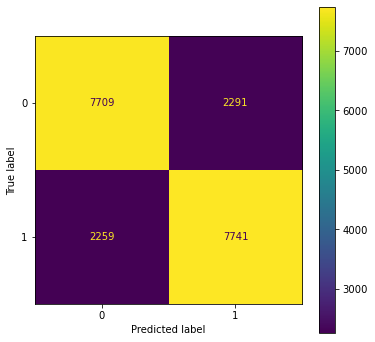

--- ROC AUC ---------------------------------------------------------------------------------------- 



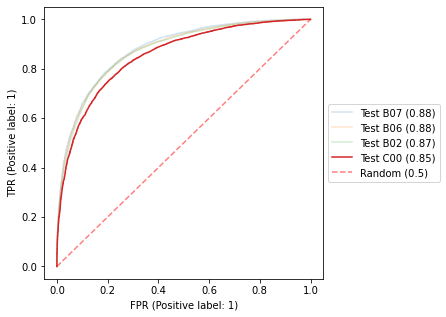

--- PRECISION RECALL AUC --------------------------------------------------------------------------- 



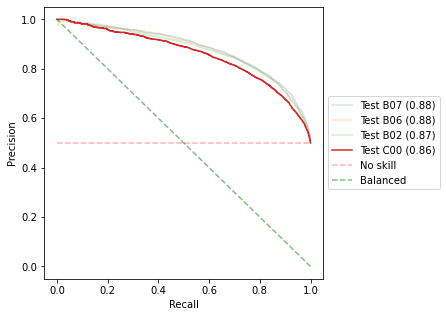

In [244]:
get_scores(model_name, **grd_log, register=True, X_ref=X_test_ready, y_ref=y_test)

---
## Comparaison des `scores` <a class="anchor" id="PREPROCESS_scores"></a> [⇪](#menu)

>#### Les scores ci-dessous ont été obtenus avec divers pré-traitements initiaux
> mais la phase final de pré-traitement à dans tous les cas utilisé **TF-IDF** comme moyen de rendre compatible les textes avec le DummyClassifier et la LogisticRegression.

In [245]:
from classification_utils import scores_df

In [246]:
scores_df

,Method,threshold,params,ROC AUC,PR AUC,F1 score,Accuracy,Precision,Recall,TP,TN,FP,FN,Training time,Inference time
0,Test A00,None,None,0.510002,0.505938,0.339013,0.51315,0.527795,0.2497,2497,7766,2234,7503,7.679453,0.609395
1,Test A03,None,None,0.866633,0.866372,0.793137,0.79745,0.810393,0.7766,7766,8183,1817,2234,36.241583,1.581173
2,Test B01,None,None,0.868323,0.866994,0.790813,0.79415,0.803843,0.7782,7782,8101,1899,2218,29.195286,2.649221
3,Test B02,None,None,0.872496,0.873931,0.793764,0.79430,0.795838,0.7917,7917,7969,2031,2083,49.224950,3.653748
4,Test B03,None,None,0.858001,0.859934,0.772767,0.77705,0.787904,0.7582,7582,7959,2041,2418,94.840376,3.613615
5,Test B04,None,None,0.858031,0.859648,0.777219,0.77840,0.781383,0.7731,7731,7837,2163,2269,81.054028,3.292211
6,Test B05,None,None,0.839388,0.840457,0.760198,0.75720,0.750927,0.7697,7697,7447,2553,2303,49.127228,3.159663
7,Test B06,None,None,0.876113,0.878281,0.790771,0.79370,0.802160,0.7797,7797,8077,1923,2203,71.764973,3.267204
8,Test B07,None,None,0.880537,0.881681,0.796749,0.79620,0.794609,0.7989,7989,7935,2065,2011,93.359180,3.359108
9,Test B08,None,None,0.861583,0.862701,0.787386,0.77885,0.758123,0.8190,8190,7387,2613,1810,156.315505,4.027334


In [247]:
scores_df.sort_values(['ROC AUC'], ascending=False)

,Method,threshold,params,ROC AUC,PR AUC,F1 score,Accuracy,Precision,Recall,TP,TN,FP,FN,Training time,Inference time
8,Test B07,None,None,0.880537,0.881681,0.796749,0.79620,0.794609,0.7989,7989,7935,2065,2011,93.359180,3.359108
7,Test B06,None,None,0.876113,0.878281,0.790771,0.79370,0.802160,0.7797,7797,8077,1923,2203,71.764973,3.267204
3,Test B02,None,None,0.872496,0.873931,0.793764,0.79430,0.795838,0.7917,7917,7969,2031,2083,49.224950,3.653748
2,Test B01,None,None,0.868323,0.866994,0.790813,0.79415,0.803843,0.7782,7782,8101,1899,2218,29.195286,2.649221
10,Test B09,None,None,0.867537,0.868180,0.788534,0.78680,0.782172,0.7950,7950,7786,2214,2050,148.707509,3.592005
1,Test A03,None,None,0.866633,0.866372,0.793137,0.79745,0.810393,0.7766,7766,8183,1817,2234,36.241583,1.581173
9,Test B08,None,None,0.861583,0.862701,0.787386,0.77885,0.758123,0.8190,8190,7387,2613,1810,156.315505,4.027334
5,Test B04,None,None,0.858031,0.859648,0.777219,0.77840,0.781383,0.7731,7731,7837,2163,2269,81.054028,3.292211
4,Test B03,None,None,0.858001,0.859934,0.772767,0.77705,0.787904,0.7582,7582,7959,2041,2418,94.840376,3.613615
11,Test C00,None,"[{'random_state': [0], 'max_iter': [3000], 'so...",0.853607,0.856885,0.772863,0.77250,0.771631,0.7741,7741,7709,2291,2259,23.066506,0.002944


In [ ]:
import FreeMobileSMS as sms
sms.send(stop=True)

# Test préliminaires

In [ ]:
import time
import pathlib

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import layers

from sklearn.model_selection import train_test_split

random_seed=0

In [ ]:
data_work = pd.read_csv(
    pathlib.Path(pathlib.Path().absolute(), 'data', 'data_nlp_1563108.csv'), 
    usecols=['target', 'lemmas_not_filtered'],
    encoding='ISO-8859-1',
)
data_work.rename(columns={'lemmas_not_filtered':'text'}, inplace=True)
display(data_work.head(), data_work.shape)

### Standardize & Tokenize

In [ ]:
text_vectorization = TextVectorization(
    output_mode='int', # int, multi_hot, count, tf_idf
    max_tokens=20000,
    ngrams=1,
    # output_sequence_length=60 # search the max size by default
)

In [ ]:
text_vectorization.adapt(data_work.text.sample(100000, random_state=0))

In [ ]:
print(text_vectorization.get_vocabulary()[:20], "...")

### Encode

In [ ]:
vocabulary = text_vectorization.get_vocabulary()
len(vocabulary)

In [ ]:
test_sentence = "I write, rewrite, and still rewrite again"

In [ ]:
encoded_sentence = text_vectorization(test_sentence)
encoded_sentence

### Decode

In [ ]:
inverse_vocab = dict(enumerate(vocabulary))

In [ ]:
decoded_sentence = " ".join([inverse_vocab[int(x)] for x in encoded_sentence])
decoded_sentence

### Divisons le jeu de données en `Train` et `Test` sets

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data_work['text'], data_work['target'], test_size=0.2, random_state=random_seed)

### Prepare dataset

In [ ]:
X_train_ready = text_vectorization(X_train)
X_test_ready = text_vectorization(X_test)

In [ ]:
X_train[:2]

In [ ]:
X_train_ready[:2]

### Inspect train_ds or test_ds

### Train model

In [ ]:
def summarize_diagnostics(history):
    
    figure = plt.figure(figsize=(8,8))
            
    # plot loss
    plt.subplot(211)
    plt.title('Cross Entropy Loss')
    plt.plot(history.history['loss'], color='blue', label='train')
    plt.plot(history.history['val_loss'], color='orange', label='val')
    plt.legend()
    
    # plot accuracy
    plt.subplot(212)
    plt.title('Classification Accuracy')
    plt.plot(history.history['accuracy'], color='blue', label='train')
    plt.plot(history.history['val_accuracy'], color='orange', label='val')
    plt.legend()
    
    # save plot to file
    #filename = sys.argv[0].split('/')[-1]
    #plt.savefig(filename + '_plot.png')
    #plt.close()
    
    plt.tight_layout(pad=1.0)

In [ ]:
from keras import layers
from keras.callbacks import EarlyStopping, ModelCheckpoint, Callback, ReduceLROnPlateau

def init_callbacks(model_name):

    # Define savepoints
    filepath = pathlib.Path("models", f"{model_name}.epoch{{epoch:02d}}-accuracy{{val_accuracy:.2f}}.hdf5")

    checkpoint = ModelCheckpoint(
        monitor="val_accuracy",
        mode="max",
        filepath=filepath,
        save_best_only=True,
        save_weights_only=True,
        verbose=1,
    )

    # Define EarlyStopping conditions
    es = EarlyStopping(
        monitor='val_loss', # 'binary_accuracy'
        mode='min', # 'max'
        patience=10,  # 6 because ReduceLROnPlateau is 5 
        min_delta=0.01, 
        restore_best_weights=True, 
        verbose=1,
    )

    # Define Automatic LearningRate adjustments
    lr_reducer = ReduceLROnPlateau(
        monitor='val_loss',
        mode='min',
        factor=0.1,
        cooldown=5,
        patience=5,
        min_lr= 0.1e-5,
        verbose=1,
    )
    
    return [checkpoint, es, lr_reducer]

In [ ]:
def architecture01(f_opti, f_loss, f_metrics, embedding):
        
    inputs = keras.Input(shape=(None,), dtype="int64")
    
    x = embedding(inputs)
    x = layers.Bidirectional(layers.LSTM(64))(x)
    x = layers.Dense(24, activation='relu')(x)
    
    predictions = layers.Dense(1, activation='sigmoid', name='predictions')(x)
    
    model = keras.Model(inputs, predictions)
    model.compile(loss=f_loss, optimizer=f_opti, metrics=f_metrics)
    
    return model

In [ ]:
from sklearn.model_selection import StratifiedKFold

skfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_seed)

In [ ]:
def train_model(X_train_, X_test_, y_train_, y_test_, vocab_size_, embedding_layer_, preprocess_desc=""):
    
    print(f"Testing model with \"{preprocess_desc}\"".upper().center(100,"-"), end='\n\n')
    
    # Prepare model
    f_opti = keras.optimizers.Adam(learning_rate=0.0005)
    f_loss = keras.losses.BinaryCrossentropy(from_logits=False)
    f_metrics = ['accuracy'] # in this context 'accuracy' == keras.metrics.BinaryAccuracy()
    
    model = architecture01(f_opti, f_loss, f_metrics, embedding_layer_)
    model.summary()
    
    t0 = time.perf_counter()
    history = model.fit(
        x=X_train_, y=y_train_, 
        validation_data=(X_test_, y_test_), 
        epochs=50, 
        batch_size=batch_size, 
        callbacks=init_callbacks(f"archi01_PREPROCESS_{preprocess_desc}"),
        verbose=1,
        # validation_split=0.2,
        # train_labels
    )
    train_time = time.perf_counter() - t0
    
    # Print accuracy scores
    loss, accuracy = model.evaluate(X_train_ready, y_train, verbose=False)
    print("\nTraining Accuracy: {:.4f}".format(accuracy))
    loss, accuracy = model.evaluate(X_test_ready, y_test, verbose=False)
    print("Testing Accuracy:  {:.4f}".format(accuracy))
    
    return history, model, train_time

In [ ]:
# Embedding simple
padding_size = X_train_ready.shape[1]
embedding_dim = 100
vocab_size = len(vocabulary)
embedding_layer = layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=padding_size, trainable=True)

In [ ]:
history_W2V300, model_W2V300, train_time = train_model(X_train_ready, X_test_ready, y_train, y_test, vocab_size, embedding_layer, "W2V300")

In [ ]:
summarize_diagnostics(history_W2V300)

### Affichons les scores du modèle

In [ ]:
t0 = time.perf_counter()
y_preds_proba = model_W2V300.predict(X_test_ready)
# y_preds_proba = pd.Series([x[0] for x in y_preds_proba])

y_preds = np.where(y_preds_proba > 0.5, 1,0)
# y_preds = pd.Series([1 if x > 0.5 else 0 for x in y_preds_proba])
inf_time = time.perf_counter() - t0

y_preds_proba.shape
y_preds.shape

In [ ]:
model_name = "NN Archi01 (PT_W2V_300 + Lemma_nof + Tokenizer4500)"
get_scores(model_name, y_pred=y_preds, y_pred_proba=y_preds_proba, register=True, X_ref=X_test_ready, y_ref=y_test, training_time=train_time, inference_time=inf_time)

In [ ]:
# Prepare model
f_opti = keras.optimizers.Adam(learning_rate=0.0005)
f_loss = keras.losses.BinaryCrossentropy(from_logits=False)
f_metrics = ['accuracy'] # in this context 'accuracy' == keras.metrics.BinaryAccuracy()
    
TEST_model = architecture01(f_opti, f_loss, f_metrics, embedding_layer)
TEST_model.summary()

In [ ]:
t0 = time.perf_counter()
y_preds_proba = TEST_model.predict(X_test_ready)
# y_preds_proba = pd.Series([x[0] for x in y_preds_proba])

y_preds = np.where(y_preds_proba > 0.5, 1,0)
# y_preds = pd.Series([1 if x > 0.5 else 0 for x in y_preds_proba])
inf_time = time.perf_counter() - t0

y_preds_proba.shape
y_preds.shape

In [ ]:
model_name = "TEST1"
get_scores(model_name, y_pred=y_preds, y_pred_proba=y_preds_proba, register=True, X_ref=X_test_ready, y_ref=y_test, training_time=train_time, inference_time=inf_time)

In [ ]:
# Restore the weights
TEST_model.load_weights('models/archi01_PREPROCESS_W2V300.epoch05-accuracy0.82.hdf5')

In [ ]:
t0 = time.perf_counter()
y_preds_proba = TEST_model.predict(X_test_ready)
# y_preds_proba = pd.Series([x[0] for x in y_preds_proba])

y_preds = np.where(y_preds_proba > 0.5, 1,0)
# y_preds = pd.Series([1 if x > 0.5 else 0 for x in y_preds_proba])
inf_time = time.perf_counter() - t0

y_preds_proba.shape
y_preds.shape

In [ ]:
TEST_model.evaluate(X_test_ready, y_test)

In [ ]:
model_name = "TEST1"
get_scores(model_name, y_pred=y_preds, y_pred_proba=y_preds_proba, register=True, X_ref=X_test_ready, y_ref=y_test, training_time=train_time, inference_time=inf_time)

> **Donc en fait, si je prend le modèle tel-quel après entrainement, il n'a PAS remis le meilleur modèle trouvé !!!**

In [ ]:
t0 = time.perf_counter()
y_preds_proba = model_W2V300.predict(X_test_ready)
# y_preds_proba = pd.Series([x[0] for x in y_preds_proba])

y_preds = np.where(y_preds_proba > 0.5, 1,0)
# y_preds = pd.Series([1 if x > 0.5 else 0 for x in y_preds_proba])
inf_time = time.perf_counter() - t0

y_preds_proba.shape
y_preds.shape

In [ ]:
model_W2V300.evaluate(X_test_ready, y_test)

In [ ]:
model_name = "NN Archi01 (PT_W2V_300 + Lemma_nof + Tokenizer4500)"
get_scores(model_name, y_pred=y_preds, y_pred_proba=y_preds_proba, register=True, X_ref=X_test_ready, y_ref=y_test, training_time=train_time, inference_time=inf_time)

## Packaging

In [ ]:
inputs = keras.Input(shape=(1,), dtype='string')
processed_inputs = text_vectorization(inputs)
outputs = TEST_model(processed_inputs)
inference_model = keras.Model(inputs, outputs)

In [ ]:
raw_text = tf.convert_to_tensor(["I like it", "I don't like it"])
inference_model(raw_text)

In [ ]:
# Compile before exporting BUT nit required for inference
inference_model.compile(optimizer='adam', loss='binary_crossentropy')

inference_model.save("models/TEST3")

In [ ]:
XXX = keras.models.load_model("models/TEST3")

In [ ]:
raw_text = tf.convert_to_tensor(["I like it", "I don't like it"])
XXX(raw_text)

---
---
---
---
---